## Tracking COVID-19 Cases

Unless you've been living under a rock, you've probably heard of an illness called Severe Acute Respiratory Syndrome Coronavirus 2 (SARS-CoV-2), the disease that causes the Coronavirus Disease 2019 (COVID-2019). The disease is considered the most infectious and deadly illness since the Spanish Flu in 1919. In response, schools have closed; Public areas have shut down because; economies have come to a grinding halt because of it, and we're all paranoid about being around other people.

Most of us have never lived through a Pandemic (unless you count the 2009 H1N1 Pandemic), so we will have no idea how bad this could possible get. Scientist have attempted to determine how deadly this dieases is compared to others throughout history, as seen in the following chart.

![stationarity comparison](https://kidquant.com/post/images/tracking-covid-cases/comparison.png)

Right now, it's assumed that this virus is just as contagious as other diseases such Polio and the Common Cold while being more deadly than these other diseases. As such, the scientific community has devoted all of their resources in finding ways to track the growth of this dieases.

The purpose of this notebook is to determine the rate at which confirmed cases of COVID-19 are growing in many places around the world.

The data I will be using for this project comes from [John Hopkins University](https://coronavirus.jhu.edu/us-map), which has developed a COVID-19 map, which tracks the number of COVID-19 cases, hospitalization, and deaths around the world.

John Hopkins also provides a [Data Repository](https://github.com/CSSEGISandData/COVID-19) of global COVID-19 cases.

### Some Basic Ideas

There are a couple of mathematical techniques known as compartmental models that are used to model infectious diseases. In these models, epidemiologist divides the population into separate groups, with the assumption that individuals in the same compartments share the same characteristics.

We are still in the early stages of COVID-19, and we are still learning more about the virus every day. To accurately forecast the growth of COVID-19, the underlying dynamics of transmission need to be determined.

The driving factors COVID-19 (as well as any other dieases) includes the following factors:

* The number of people on average becomes infected. This is known as the "reproduction rate," or $R_{0}$. Basically, if one person becomes infected, how many people will this person infect on average by coming into contact with other people? The World Health Organization is has estimated that this rate is around [1.4 - 2.5 people in the past](https://www.who.int/news-room/detail/23-01-2020-statement-on-the-meeting-of-the-international-health-regulations-(2005)-emergency-committee-regarding-the-outbreak-of-novel-coronavirus-(2019-ncov)).
* The amount of time it takes for the virus to double is measured by the growth cumulative confirmed cases, which is different from the frowth of infections. The doubling as time passes is a trend known as Exponential Growth.
* The doubling time calculated here measures the growth of cumulative confirmed cases, which is different from the growth of infections. For example, if a country suddenly ramps up testing, then the number of confirmed cases will rapidly rise. Still, infections may not be growing at the same rate.

![](https://kidquant.com/post/images/tracking-covid-cases/SIRanimationlow.gif)

The following graph shows how an epidemic might spread across a network over time. Blue dots are susceptible individuals, while red dots are infected people. Two dots are connected by a line if they are in contact with each other, and the more connections a person has, the bigger their dot is on the network.

Exponential growth models start with a small number of infected individuals in a large population, such as when the virus first emerged in Wuhan, China. However, it's not a good model once a large number of people have been infected. This is because the chance of an infected person contacting a susceptible person declines, simply because there are fewer susceptible people around, and a growing fraction of people have recovered and developed some level of immunity.

Eventually, the chances of an infected person contacting a susceptible person becomes low enough that the rate of infection decreases, leading to fewer cases and eventually, the end of the viral spread.

#### Importing the Modules

We can start by importing the necessary packages for this project. `pandas` allows us to manipulate dataframes easily, while `numpy` allows us to conduct numerical computation on python array and dataframes. `matplotlib` is used for visualizations, which we will use to map the growth of COVID-19 cases, as well as the reinfection rate.

We will also use the `curve_fit` method from the `scipy` module for the purposes of curve fitting. Doubling times inferred from curve fitting are not necessarily the currency or most recent doubling times. For areas where the growth is still exponential, the inferred doubling time gives us a picture of the overall rate of growth. For other nations (such as South Korea), we will use a logistic function to fit the data instead.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

df = pd.read_csv('time_series_covid19_confirmed_global.csv')

df.head(10)

Province/State       Country/Region      Lat      Long  \
0                           NaN          Afghanistan  33.0000   65.0000   
1                           NaN              Albania  41.1533   20.1683   
2                           NaN              Algeria  28.0339    1.6596   
3                           NaN              Andorra  42.5063    1.5218   
4                           NaN               Angola -11.2027   17.8739   
5                           NaN  Antigua and Barbuda  17.0608  -61.7964   
6                           NaN            Argentina -38.4161  -63.6167   
7                           NaN              Armenia  40.0691   45.0382   
8  Australian Capital Territory            Australia -35.4735  149.0124   
9               New South Wales            Australia -33.8688  151.2093   

   1/22/2020  1/23/2020  1/24/2020  1/25/2020  1/26/2020  1/27/2020  ...  \
0          0          0          0          0          0          0  ...   
1          0          0          0          0          0          0  ...   
2          0          0          0          0          0          0  ...   
3          0          0          0          0          0          0  ...   
4          0          0          0          0          0          0  ...   
5          0          0          0          0          0          0  ...   
6          0          0          0          0          0          0  ...   
7          0          0          0          0          0          0  ...   
8          0          0          0          0          0          0  ...   
9          0          0          0          0          3          4  ...   

   4/3/2020  4/4/2020  4/5/2020  4/6/2020  4/7/2020  4/8/2020  4/9/2020  \
0       281       299       349       367       423       444       484   
1       304       333       361       377       383       400       409   
2      1171      1251      1320      1423      1468      1572      1666   
3       439       466       501       525       545       564       583   
4         8        10        14        16        17        19        19   
5        15        15        15        15        19        19        19   
6      1265      1451      1451      1554      1628      1715      1795   
7       736       770       822       833       853       881       921   
8        91        93        96        96        96        99       100   
9      2389      2493      2580      2637      2686      2734      2773   

   4/10/2020  4/11/2020  4/12/2020  
0        521        555        607  
1        416        433        446  
2       1761       1825       1914  
3        601        601        638  
4         19         19         19  
5         19         21         21  
6       1975       1975       2142  
7        937        967       1013  
8        103        103        103  
9       2822       2857       2857  

[10 rows x 86 columns]

As we can see from the first 10 rows of the data frame, the data is organized as follows: Province/State, Country/Region, Latitude, Longitude, and a time series of dates. The time series represents the number of NEW cases recorded each day. The first recorded COVID-19 case dates back to January 22nd, which is where the time series of this data conveniently starts.

First, we're going to aggregate the daily Coronavirus cases by each country, rather than the Province or State. We're going to sort these values in ascending order and filter our nations with more than 1,000 cases thus far. This gives us roughly 70 countries to work with.

In [2]:
# calculates the sum of all cases by region/country from the start of the index to the end

cases = df.iloc[:,[1,-1]].groupby('Country/Region').sum()
mostrecentdate = cases.columns[0]
print('\nTotal number of cases (in countries with at least 100  cases) as of', mostrecentdate)

cases = cases.sort_values(by = mostrecentdate, ascending = False)
cases = cases[cases[mostrecentdate] >= 1000]
cases


Total number of cases (in countries with at least 100  cases) as of 4/12/2020


4/12/2020
Country/Region                   
US                         555313
Spain                      166831
Italy                      156363
Germany                    127854
France                     121712
...                           ...
Bahrain                      1136
Azerbaijan                   1098
Lithuania                    1053
Armenia                      1013
Bosnia and Herzegovina       1009

[70 rows x 1 columns]

As we can see, the U.S. has the highest number of COVID causes in the world. The nation crossed that milestone [sometime last week](https://www.bbc.com/news/world-us-canada-52239261). Right behind the U.S. is Spain, Italy, Germany, and France. As mentioned previously, as nations conduct more testing, we can confirm more cases.

Next we will be fitting the graph on a Logistic Curve, which is commonly used to represent growth processes.

$$f(x)=\frac{\alpha_{0}-\alpha_{1}}{1+(x/\alpha_{2})^{\alpha_{3}}}+\alpha_{1}$$

The logistic curve has determined by the 4 parameters:

1. **Initial Value**: The value of the curve as $x$ goes to zero.
2. **Final Value**: The value of the curve as $x$ foes to infinity.
3. **Center**: The halfway point in the transition from Initial Value to Final Value.
4. **Hill Slope**: The Hill slope of the curve.

We will also create a python function for the exponential function. Both will be utilizes for determining the trend.

In [3]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

Finally, we're going to create a function that allows us to plot historical case for each country, which will vary throughout time. This will involve create a time series array for each individual country. 

For each country, we record the most recent cases from this week, as well as the number of cases from the same time period one week ago. We will use this information to calculate a ratio, which will serve as the one-day growth rate, weekly growth rate, and the growth factor for the exponential function. The growth factor is what's used to measure the amount of time it takes cases to double (which is currently every 3 days for most of the Western world).

The code will attempt to create an exponential curve fit and a logistic curve fit, based on the trend the nation is experiencing. We estimate the fit by simply calculating the the sum of total residuals relative to the total sum of squares.

$$R^{2}=1-\frac{SS_{RES}}{SS_{TOT}}=1-\frac{\sum_{i}(y_{i}-\hat{y}_{i})^{2}}{\sum_{i}(y_{i}-\bar{y}_{i})^{2}}$$

Once the code has modeled both functions, it will determine if a logistic or exponential curve fits better (the program may also use both if it is unable to determine which curve fits better). Based on that calculation, the program will return the **Weekly increase**, **Daily increase**, and the **Doubling time**, as well as the $R^{2}$ and the amount of time it takes for cases to double. After these calculations are done, the code will return a plot for each country.

In [4]:
def plotCases(dataframe, column, country):
    
    col = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    col = pd.DataFrame(col)
    col.columns = ['Cases']
    col = col.loc[col['Cases'] > 0]
    
    y = np.array(col['Cases'])
    x = np.arange(y.size)
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed cases on',col.index[-1],'\t',current)
            print('\tConfirmed cases on',col.index[-8],'\t',lastweek)
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time (represents recent growth):',recentdbltime,'days')

    plt.figure(figsize=(10,5))
    plt.plot(x, y, 'ko', label="Original Data")
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=10000)
        lerror = np.sqrt(np.diag(lpcov))
        
        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])
        
        # calculate R^2
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  
        
        if logisticr2 > 0.95:
            plt.plot(x, logistic(x, *lpopt), 'b--', label="Logistic Curve Fit")
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            logisticworked = True
    
    except:
        pass
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=10000)
        eerror = np.sqrt(np.diag(epcov))
        
        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])
        
        # calculate R^2
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)
        
        if expr2 > 0.95:
            plt.plot(x, exponential(x, *epopt), 'r--', label="Exponential Curve Fit")
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            exponentialworked = True
            
    except:
        pass
    
    plt.title(country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Cases', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()
    
    if logisticworked and exponentialworked:
        if round(logisticr2,2) > round(expr2,2):
            return [ldoubletime, ldoubletimeerror, recentdbltime]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime]
    
    else:
        return [float('NaN'), float('NaN'), recentdbltime]

After this, we will create list so that we will store the data for printing.



US

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 555313
	Confirmed cases on 4/5/2020 	 336802
	Ratio: 1.65
	Weekly increase: 64.9 %
	Daily increase: 7.4 % per day
	Doubling Time (represents recent growth): 9.7 days

** Based on Logistic Fit**

	R^2: 0.9993115027050814
	Doubling Time (during middle of growth):  7.04 (± 0.21 ) days

** Based on Exponential Fit **

	R^2: 0.9814979515818895
	Doubling Time (represents overall growth):  6.42 (± 0.41 ) days


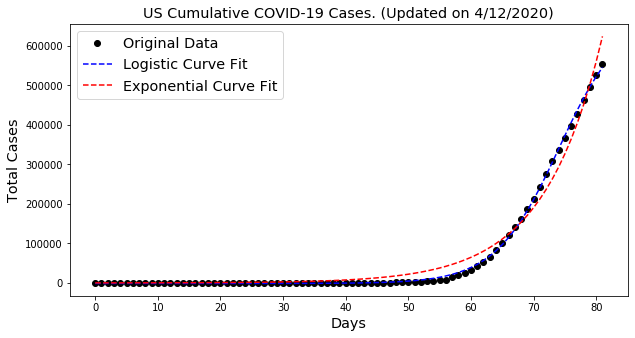



Spain

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 166831
	Confirmed cases on 4/5/2020 	 131646
	Ratio: 1.27
	Weekly increase: 26.7 %
	Daily increase: 3.4 % per day
	Doubling Time (represents recent growth): 20.5 days

** Based on Logistic Fit**

	R^2: 0.9994359769314535
	Doubling Time (during middle of growth):  7.21 (± 0.19 ) days


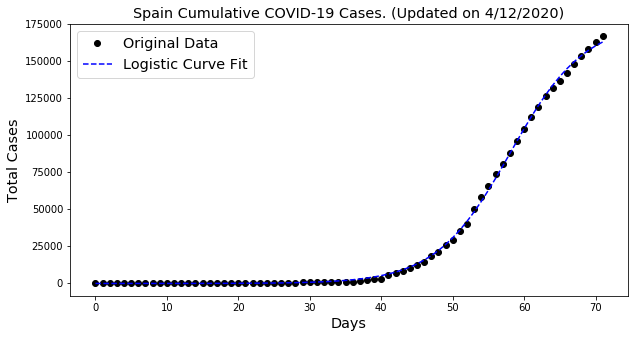



Italy

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 156363
	Confirmed cases on 4/5/2020 	 128948
	Ratio: 1.21
	Weekly increase: 21.3 %
	Daily increase: 2.8 % per day
	Doubling Time (represents recent growth): 25.2 days

** Based on Logistic Fit**

	R^2: 0.9988335579850156
	Doubling Time (during middle of growth):  9.47 (± 0.36 ) days


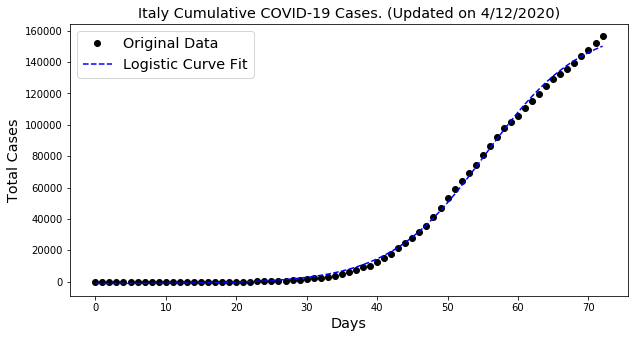



Germany

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 127854
	Confirmed cases on 4/5/2020 	 100123
	Ratio: 1.28
	Weekly increase: 27.7 %
	Daily increase: 3.6 % per day
	Doubling Time (represents recent growth): 19.8 days

** Based on Logistic Fit**

	R^2: 0.9992061269239381
	Doubling Time (during middle of growth):  7.69 (± 0.24 ) days


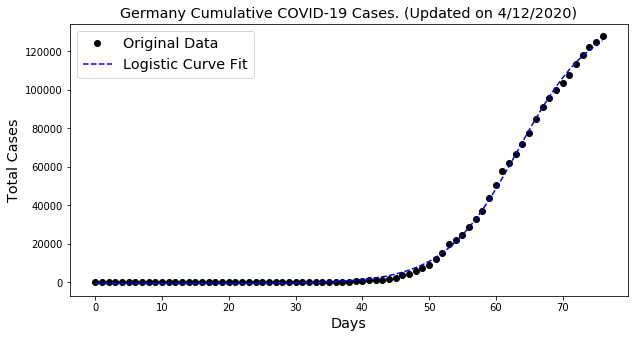



France

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 121712
	Confirmed cases on 4/5/2020 	 71412
	Ratio: 1.7
	Weekly increase: 70.4 %
	Daily increase: 7.9 % per day
	Doubling Time (represents recent growth): 9.1 days

** Based on Logistic Fit**

	R^2: 0.9925656032513666
	Doubling Time (during middle of growth):  9.59 (± 0.96 ) days

** Based on Exponential Fit **

	R^2: 0.9766726437447081
	Doubling Time (represents overall growth):  7.7 (± 0.58 ) days


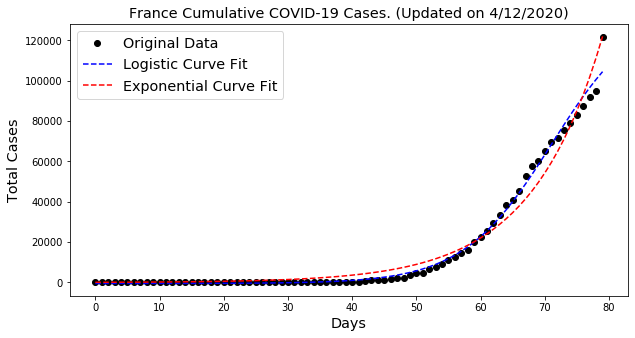



United Kingdom

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 85206
	Confirmed cases on 4/5/2020 	 48436
	Ratio: 1.76
	Weekly increase: 75.9 %
	Daily increase: 8.4 % per day
	Doubling Time (represents recent growth): 8.6 days

** Based on Logistic Fit**

	R^2: 0.999158298557826
	Doubling Time (during middle of growth):  8.07 (± 0.29 ) days

** Based on Exponential Fit **

	R^2: 0.989729146491149
	Doubling Time (represents overall growth):  6.31 (± 0.32 ) days


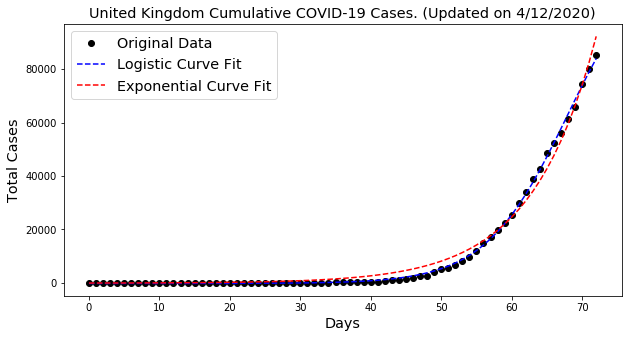



China

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 83134
	Confirmed cases on 4/5/2020 	 82602
	Ratio: 1.01
	Weekly increase: 0.6 %
	Daily increase: 0.1 % per day
	Doubling Time (represents recent growth): 755.8 days

** Based on Logistic Fit**

	R^2: 0.9958308190092988
	Doubling Time (during middle of growth):  6.64 (± 0.45 ) days


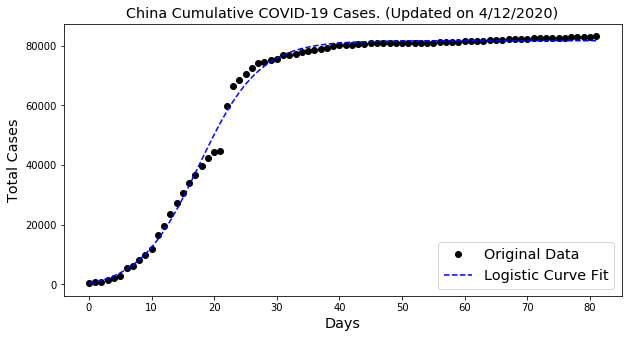



Iran

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 71686
	Confirmed cases on 4/5/2020 	 58226
	Ratio: 1.23
	Weekly increase: 23.1 %
	Daily increase: 3.0 % per day
	Doubling Time (represents recent growth): 23.3 days

** Based on Logistic Fit**

	R^2: 0.9976704451455969
	Doubling Time (during middle of growth):  13.61 (± 1.19 ) days


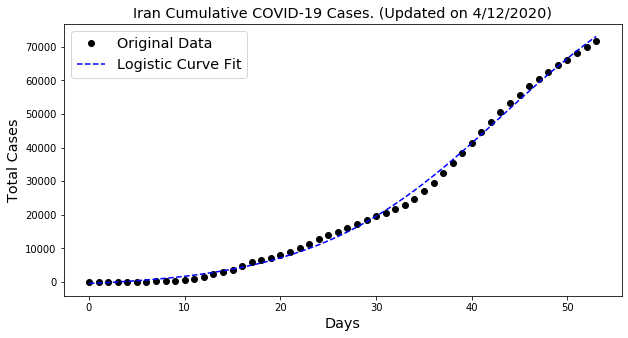



Turkey

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 56956
	Confirmed cases on 4/5/2020 	 27069
	Ratio: 2.1
	Weekly increase: 110.4 %
	Daily increase: 11.2 % per day
	Doubling Time (represents recent growth): 6.5 days

** Based on Logistic Fit**

	R^2: 0.9984756774933103
	Doubling Time (during middle of growth):  7.65 (± 0.71 ) days


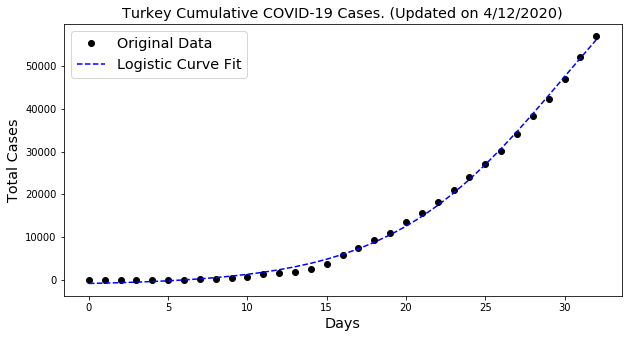



Belgium

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 29647
	Confirmed cases on 4/5/2020 	 19691
	Ratio: 1.51
	Weekly increase: 50.6 %
	Daily increase: 6.0 % per day
	Doubling Time (represents recent growth): 11.9 days

** Based on Logistic Fit**

	R^2: 0.9985746341263927
	Doubling Time (during middle of growth):  7.89 (± 0.36 ) days

** Based on Exponential Fit **

	R^2: 0.978216187260181
	Doubling Time (represents overall growth):  7.58 (± 0.62 ) days


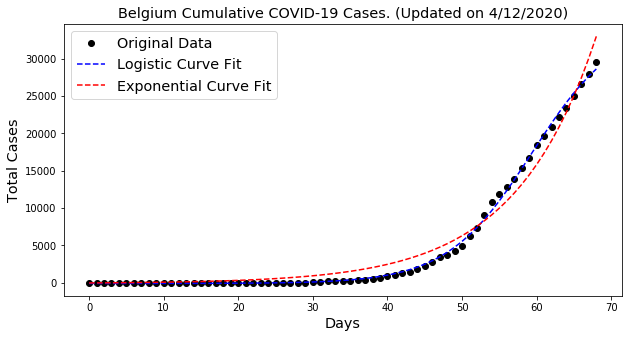



Netherlands

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 25746
	Confirmed cases on 4/5/2020 	 17953
	Ratio: 1.43
	Weekly increase: 43.4 %
	Daily increase: 5.3 % per day
	Doubling Time (represents recent growth): 13.5 days

** Based on Logistic Fit**

	R^2: 0.9983121517675215
	Doubling Time (during middle of growth):  9.27 (± 0.64 ) days


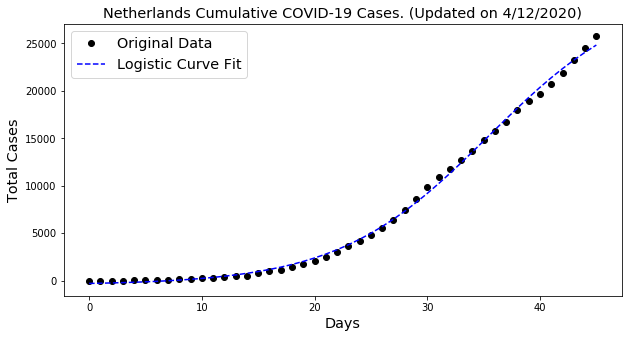



Switzerland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 25415
	Confirmed cases on 4/5/2020 	 21100
	Ratio: 1.2
	Weekly increase: 20.5 %
	Daily increase: 2.7 % per day
	Doubling Time (represents recent growth): 26.1 days

** Based on Logistic Fit**

	R^2: 0.9979039241608904
	Doubling Time (during middle of growth):  7.94 (± 0.52 ) days


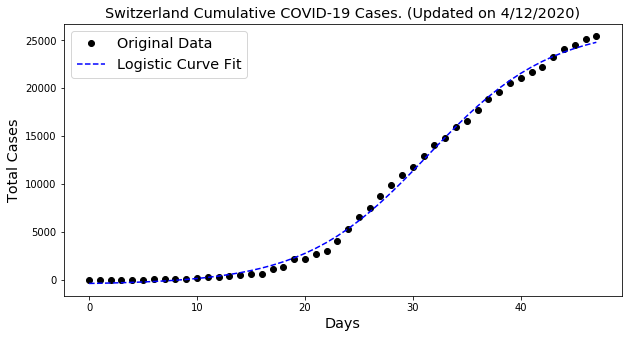



Canada

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 24299
	Confirmed cases on 4/5/2020 	 15756
	Ratio: 1.54
	Weekly increase: 54.2 %
	Daily increase: 6.4 % per day
	Doubling Time (represents recent growth): 11.2 days

** Based on Logistic Fit**

	R^2: 0.9992884834866197
	Doubling Time (during middle of growth):  7.12 (± 0.22 ) days

** Based on Exponential Fit **

	R^2: 0.9818674742292905
	Doubling Time (represents overall growth):  6.7 (± 0.44 ) days


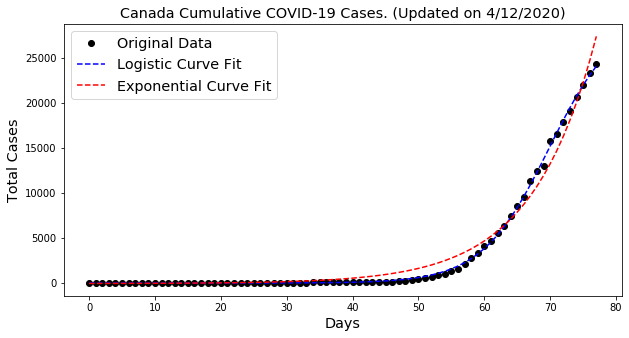



Brazil

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 22192
	Confirmed cases on 4/5/2020 	 11130
	Ratio: 1.99
	Weekly increase: 99.4 %
	Daily increase: 10.4 % per day
	Doubling Time (represents recent growth): 7.0 days

** Based on Logistic Fit**

	R^2: 0.9986341084399406
	Doubling Time (during middle of growth):  8.28 (± 0.53 ) days

** Based on Exponential Fit **

	R^2: 0.9912877047259258
	Doubling Time (represents overall growth):  5.8 (± 0.37 ) days


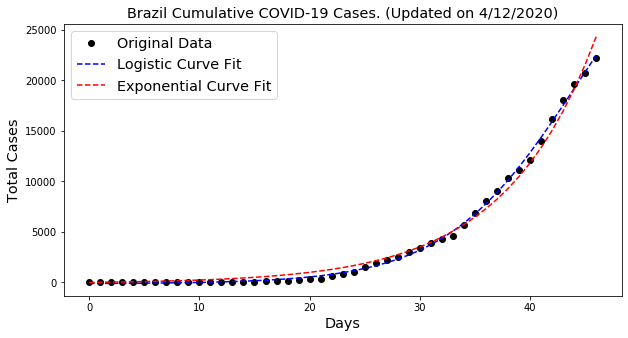



Portugal

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 16585
	Confirmed cases on 4/5/2020 	 11278
	Ratio: 1.47
	Weekly increase: 47.1 %
	Daily increase: 5.7 % per day
	Doubling Time (represents recent growth): 12.6 days

** Based on Logistic Fit**

	R^2: 0.9974750841702111
	Doubling Time (during middle of growth):  7.73 (± 0.65 ) days


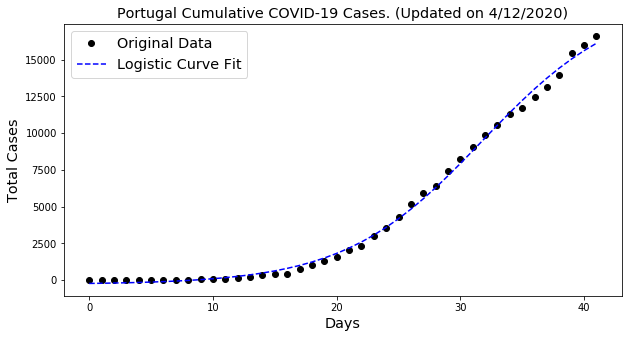



Russia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 15770
	Confirmed cases on 4/5/2020 	 5389
	Ratio: 2.93
	Weekly increase: 192.6 %
	Daily increase: 16.6 % per day
	Doubling Time (represents recent growth): 4.5 days

** Based on Exponential Fit **

	R^2: 0.998715017089868
	Doubling Time (represents overall growth):  4.43 (± 0.08 ) days


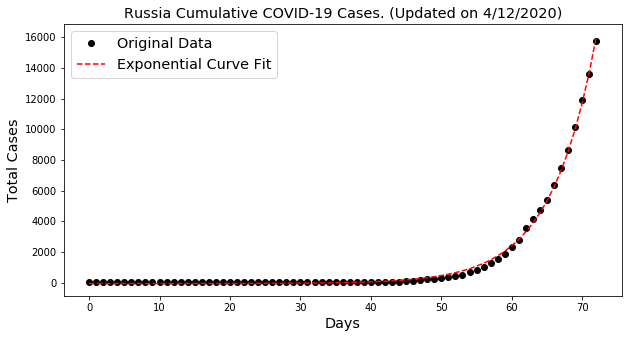



Austria

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 13945
	Confirmed cases on 4/5/2020 	 12051
	Ratio: 1.16
	Weekly increase: 15.7 %
	Daily increase: 2.1 % per day
	Doubling Time (represents recent growth): 33.2 days

** Based on Logistic Fit**

	R^2: 0.9988806187517598
	Doubling Time (during middle of growth):  6.16 (± 0.28 ) days


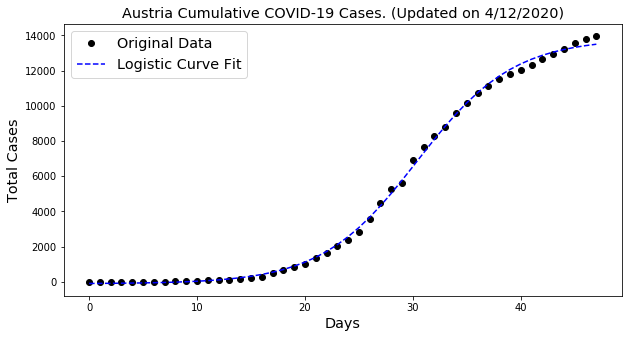



Israel

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 11145
	Confirmed cases on 4/5/2020 	 8430
	Ratio: 1.32
	Weekly increase: 32.2 %
	Daily increase: 4.1 % per day
	Doubling Time (represents recent growth): 17.4 days

** Based on Logistic Fit**

	R^2: 0.9984904349700935
	Doubling Time (during middle of growth):  5.92 (± 0.31 ) days


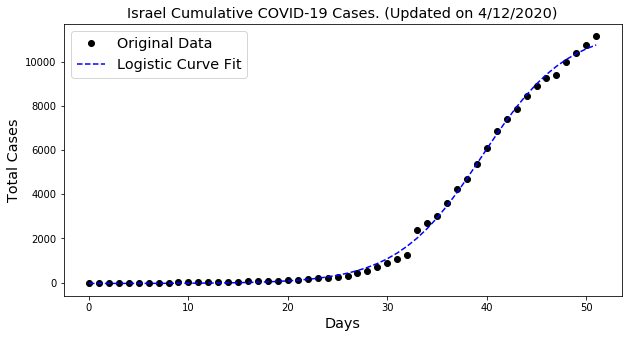



Korea, South

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 10512
	Confirmed cases on 4/5/2020 	 10237
	Ratio: 1.03
	Weekly increase: 2.7 %
	Daily increase: 0.4 % per day
	Doubling Time (represents recent growth): 183.0 days

** Based on Logistic Fit**

	R^2: 0.9899636842699842
	Doubling Time (during middle of growth):  6.71 (± 0.73 ) days


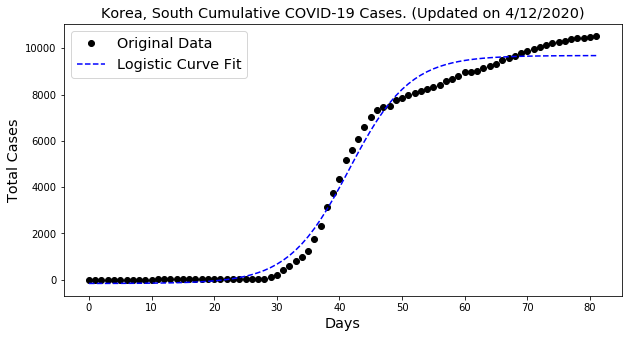



Sweden

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 10483
	Confirmed cases on 4/5/2020 	 6830
	Ratio: 1.53
	Weekly increase: 53.5 %
	Daily increase: 6.3 % per day
	Doubling Time (represents recent growth): 11.3 days

** Based on Logistic Fit**

	R^2: 0.9987949794336303
	Doubling Time (during middle of growth):  11.99 (± 0.56 ) days

** Based on Exponential Fit **

	R^2: 0.9931314517106384
	Doubling Time (represents overall growth):  8.59 (± 0.38 ) days


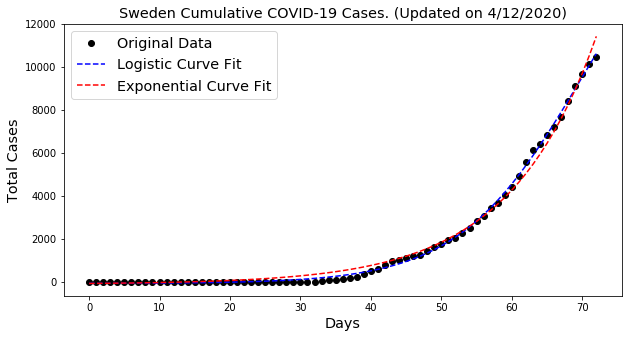



Ireland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 9655
	Confirmed cases on 4/5/2020 	 4994
	Ratio: 1.93
	Weekly increase: 93.3 %
	Daily increase: 9.9 % per day
	Doubling Time (represents recent growth): 7.4 days

** Based on Logistic Fit**

	R^2: 0.9939172185969573
	Doubling Time (during middle of growth):  14.09 (± 3.18 ) days

** Based on Exponential Fit **

	R^2: 0.9883051093736931
	Doubling Time (represents overall growth):  6.46 (± 0.53 ) days


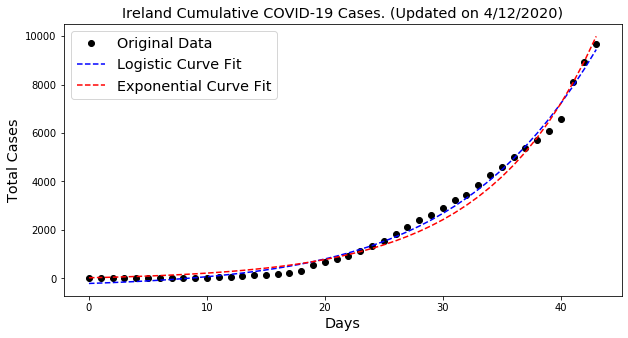



India

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 9205
	Confirmed cases on 4/5/2020 	 3588
	Ratio: 2.57
	Weekly increase: 156.5 %
	Daily increase: 14.4 % per day
	Doubling Time (represents recent growth): 5.1 days

** Based on Exponential Fit **

	R^2: 0.9945201689297992
	Doubling Time (represents overall growth):  4.94 (± 0.18 ) days


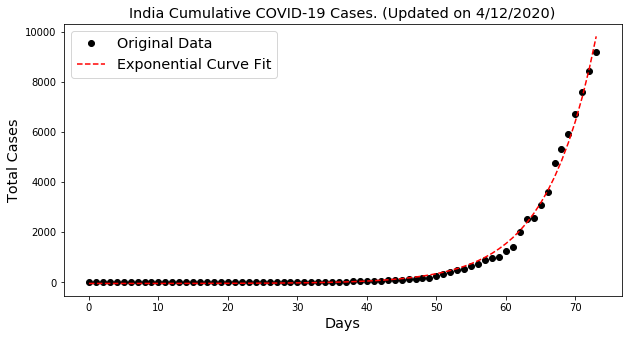



Peru

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 7519
	Confirmed cases on 4/5/2020 	 2281
	Ratio: 3.3
	Weekly increase: 229.6 %
	Daily increase: 18.6 % per day
	Doubling Time (represents recent growth): 4.1 days

** Based on Logistic Fit**

	R^2: 0.9927359212917445
	Doubling Time (during middle of growth):  7.09 (± 1.34 ) days

** Based on Exponential Fit **

	R^2: 0.9923733361298158
	Doubling Time (represents overall growth):  4.08 (± 0.26 ) days


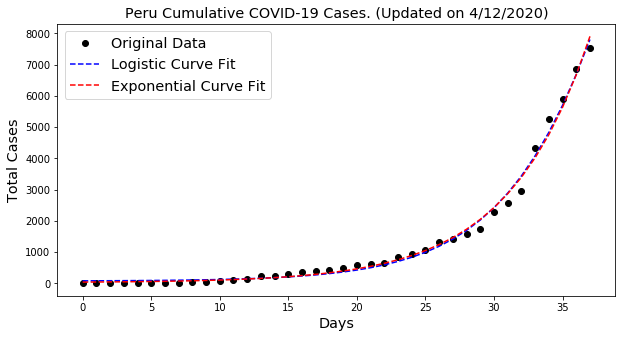



Ecuador

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 7466
	Confirmed cases on 4/5/2020 	 3646
	Ratio: 2.05
	Weekly increase: 104.8 %
	Daily increase: 10.8 % per day
	Doubling Time (represents recent growth): 6.8 days

** Based on Logistic Fit**

	R^2: 0.9795095445174087
	Doubling Time (during middle of growth):  14.41 (± 6.76 ) days

** Based on Exponential Fit **

	R^2: 0.9778524524184782
	Doubling Time (represents overall growth):  6.63 (± 0.78 ) days


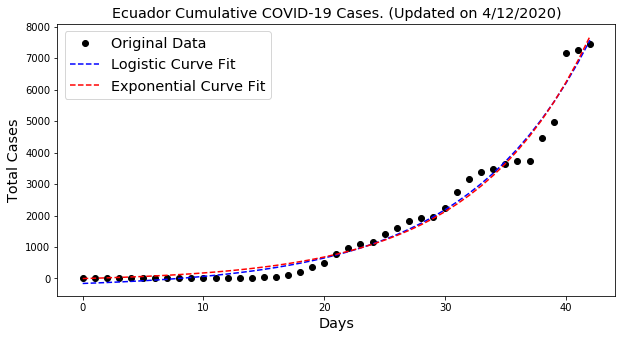



Chile

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 7213
	Confirmed cases on 4/5/2020 	 4471
	Ratio: 1.61
	Weekly increase: 61.3 %
	Daily increase: 7.1 % per day
	Doubling Time (represents recent growth): 10.1 days

** Based on Logistic Fit**

	R^2: 0.998778641150127
	Doubling Time (during middle of growth):  8.61 (± 0.57 ) days

** Based on Exponential Fit **

	R^2: 0.9719810277113162
	Doubling Time (represents overall growth):  6.27 (± 0.85 ) days


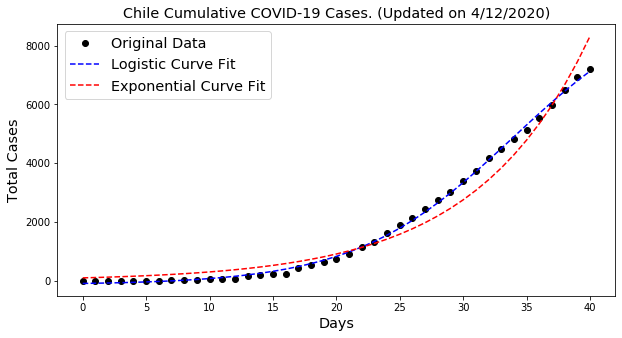



Japan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 6748
	Confirmed cases on 4/5/2020 	 3139
	Ratio: 2.15
	Weekly increase: 115.0 %
	Daily increase: 11.6 % per day
	Doubling Time (represents recent growth): 6.3 days

** Based on Logistic Fit**

	R^2: 0.9924720281101724
	Doubling Time (during middle of growth):  15.19 (± 0.63 ) days

** Based on Exponential Fit **

	R^2: 0.992472028239167
	Doubling Time (represents overall growth):  7.6 (± 0.31 ) days


C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in sqrt


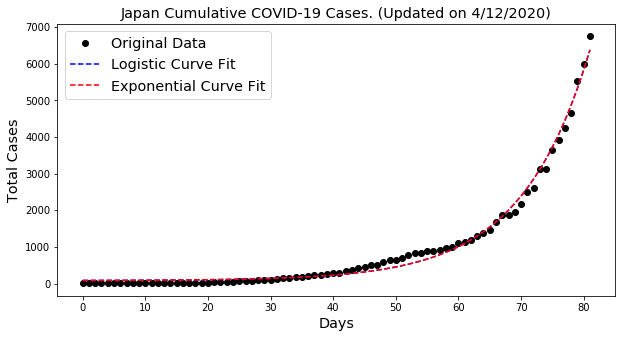



Poland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 6674
	Confirmed cases on 4/5/2020 	 4102
	Ratio: 1.63
	Weekly increase: 62.7 %
	Daily increase: 7.2 % per day
	Doubling Time (represents recent growth): 10.0 days

** Based on Logistic Fit**

	R^2: 0.9997366638993523
	Doubling Time (during middle of growth):  8.75 (± 0.28 ) days

** Based on Exponential Fit **

	R^2: 0.9780281674028553
	Doubling Time (represents overall growth):  6.23 (± 0.76 ) days


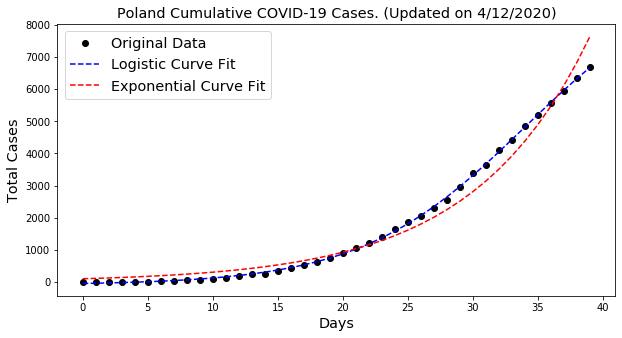



Norway

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 6525
	Confirmed cases on 4/5/2020 	 5687
	Ratio: 1.15
	Weekly increase: 14.7 %
	Daily increase: 2.0 % per day
	Doubling Time (represents recent growth): 35.3 days

** Based on Logistic Fit**

	R^2: 0.9795090666103016
	Doubling Time (during middle of growth):  -54.28 (± -41.21 ) days


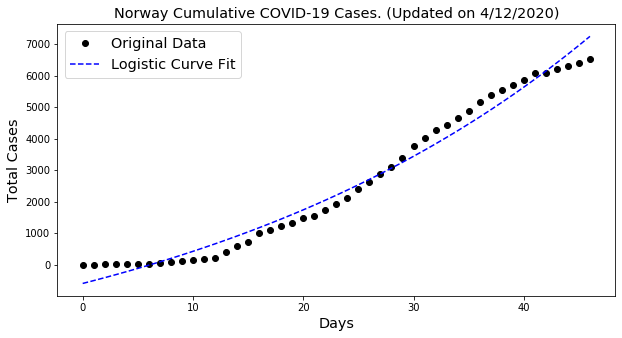



Denmark

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 6369
	Confirmed cases on 4/5/2020 	 4561
	Ratio: 1.4
	Weekly increase: 39.6 %
	Daily increase: 4.9 % per day
	Doubling Time (represents recent growth): 14.5 days

** Based on Logistic Fit**

	R^2: 0.9956427480206734
	Doubling Time (during middle of growth):  15.48 (± 2.82 ) days

** Based on Exponential Fit **

	R^2: 0.9521256035672526
	Doubling Time (represents overall growth):  7.19 (± 1.17 ) days


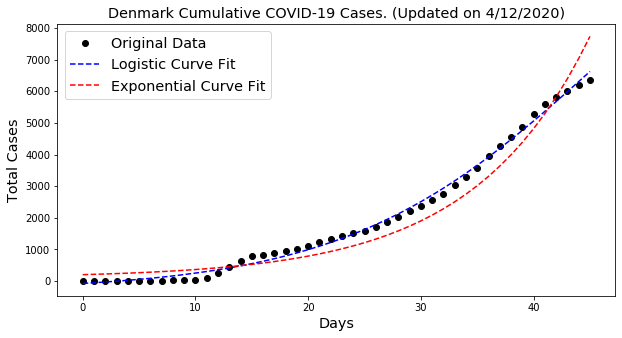



Australia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 6315
	Confirmed cases on 4/5/2020 	 5687
	Ratio: 1.11
	Weekly increase: 11.0 %
	Daily increase: 1.5 % per day
	Doubling Time (represents recent growth): 46.3 days

** Based on Logistic Fit**

	R^2: 0.999649241432788
	Doubling Time (during middle of growth):  5.55 (± 0.11 ) days


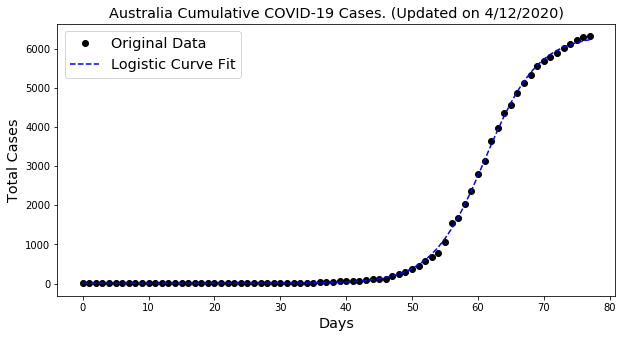



Romania

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 6300
	Confirmed cases on 4/5/2020 	 3864
	Ratio: 1.63
	Weekly increase: 63.0 %
	Daily increase: 7.2 % per day
	Doubling Time (represents recent growth): 9.9 days

** Based on Logistic Fit**

	R^2: 0.9985798156830936
	Doubling Time (during middle of growth):  8.15 (± 0.5 ) days

** Based on Exponential Fit **

	R^2: 0.9850888714849358
	Doubling Time (represents overall growth):  7.08 (± 0.65 ) days


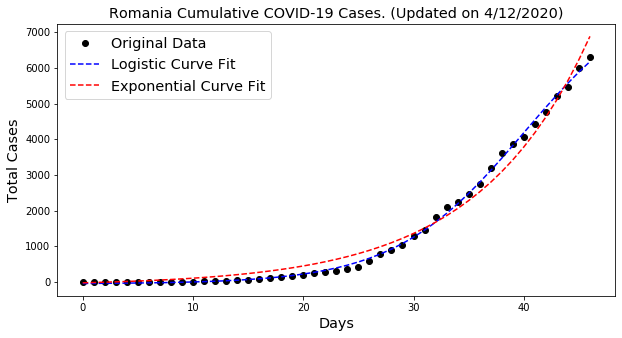



Czechia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 5991
	Confirmed cases on 4/5/2020 	 4587
	Ratio: 1.31
	Weekly increase: 30.6 %
	Daily increase: 3.9 % per day
	Doubling Time (represents recent growth): 18.2 days

** Based on Logistic Fit**

	R^2: 0.9990450145893084
	Doubling Time (during middle of growth):  8.14 (± 0.41 ) days


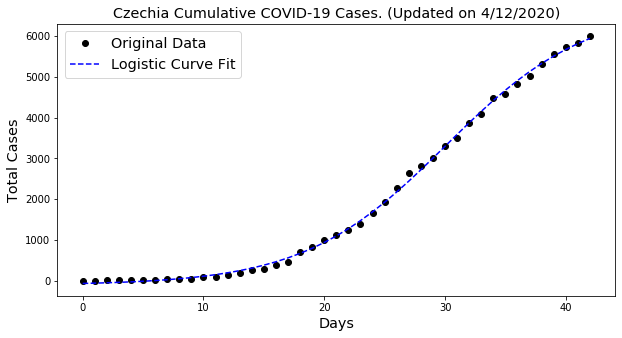



Pakistan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 5230
	Confirmed cases on 4/5/2020 	 3157
	Ratio: 1.66
	Weekly increase: 65.7 %
	Daily increase: 7.5 % per day
	Doubling Time (represents recent growth): 9.6 days

** Based on Logistic Fit**

	R^2: 0.9967101682805588
	Doubling Time (during middle of growth):  10.1 (± 1.07 ) days

** Based on Exponential Fit **

	R^2: 0.9867696081302706
	Doubling Time (represents overall growth):  7.69 (± 0.69 ) days


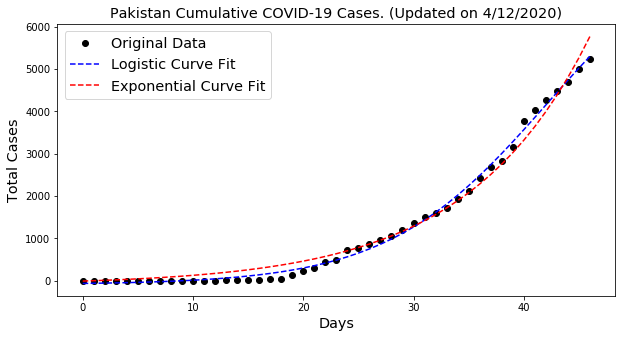



Malaysia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 4683
	Confirmed cases on 4/5/2020 	 3662
	Ratio: 1.28
	Weekly increase: 27.9 %
	Daily increase: 3.6 % per day
	Doubling Time (represents recent growth): 19.7 days

** Based on Logistic Fit**

	R^2: 0.997827828051521
	Doubling Time (during middle of growth):  9.14 (± 0.47 ) days

** Based on Exponential Fit **

	R^2: 0.9702365400021921
	Doubling Time (represents overall growth):  10.53 (± 0.99 ) days


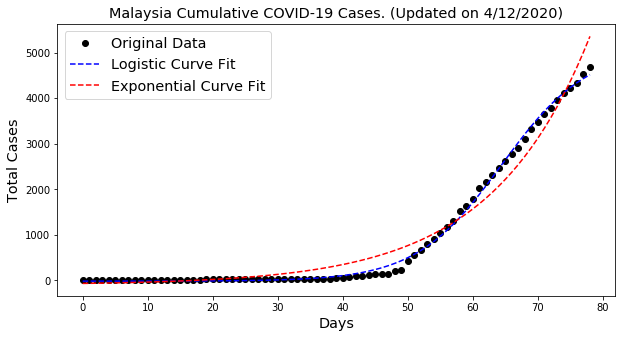



Mexico

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 4661
	Confirmed cases on 4/5/2020 	 2143
	Ratio: 2.17
	Weekly increase: 117.5 %
	Daily increase: 11.7 % per day
	Doubling Time (represents recent growth): 6.2 days

** Based on Logistic Fit**

	R^2: 0.9991365016492837
	Doubling Time (during middle of growth):  9.91 (± 0.6 ) days

** Based on Exponential Fit **

	R^2: 0.9979404196199959
	Doubling Time (represents overall growth):  6.2 (± 0.2 ) days


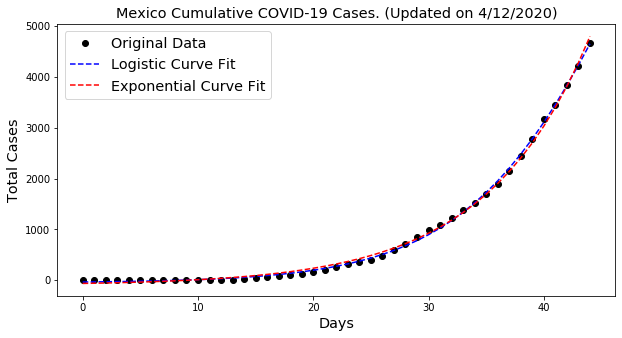



Philippines

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 4648
	Confirmed cases on 4/5/2020 	 3246
	Ratio: 1.43
	Weekly increase: 43.2 %
	Daily increase: 5.3 % per day
	Doubling Time (represents recent growth): 13.5 days

** Based on Logistic Fit**

	R^2: 0.9981142401425973
	Doubling Time (during middle of growth):  5.61 (± 0.28 ) days

** Based on Exponential Fit **

	R^2: 0.965620881476711
	Doubling Time (represents overall growth):  7.64 (± 0.74 ) days


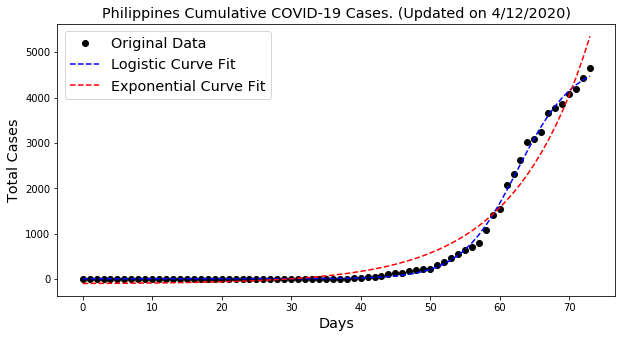



Saudi Arabia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 4462
	Confirmed cases on 4/5/2020 	 2402
	Ratio: 1.86
	Weekly increase: 85.8 %
	Daily increase: 9.3 % per day
	Doubling Time (represents recent growth): 7.8 days

** Based on Logistic Fit**

	R^2: 0.9958136752563023
	Doubling Time (during middle of growth):  14.78 (± 3.08 ) days

** Based on Exponential Fit **

	R^2: 0.9918725887967471
	Doubling Time (represents overall growth):  7.41 (± 0.57 ) days


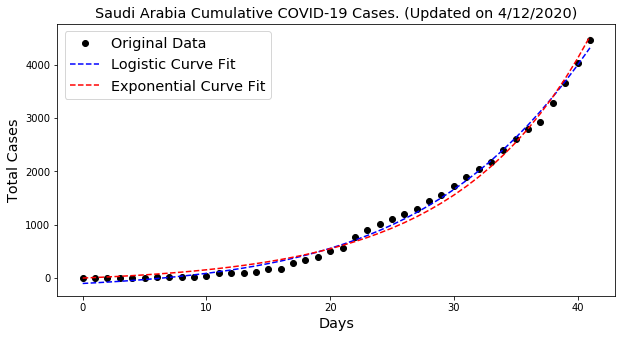



Indonesia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 4241
	Confirmed cases on 4/5/2020 	 2273
	Ratio: 1.87
	Weekly increase: 86.6 %
	Daily increase: 9.3 % per day
	Doubling Time (represents recent growth): 7.8 days

** Based on Logistic Fit**

	R^2: 0.9978110686947793
	Doubling Time (during middle of growth):  13.92 (± 1.94 ) days

** Based on Exponential Fit **

	R^2: 0.9937705449624955
	Doubling Time (represents overall growth):  7.48 (± 0.5 ) days


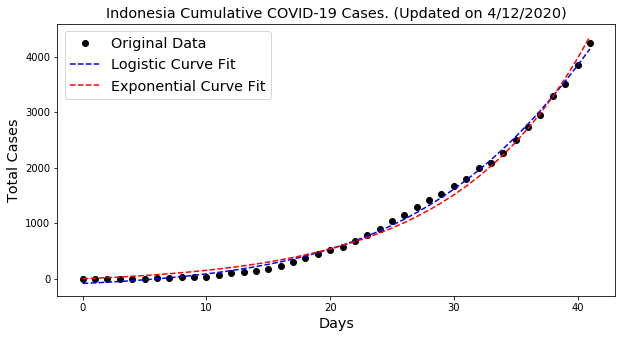



United Arab Emirates

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 4123
	Confirmed cases on 4/5/2020 	 1799
	Ratio: 2.29
	Weekly increase: 129.2 %
	Daily increase: 12.6 % per day
	Doubling Time (represents recent growth): 5.9 days

** Based on Exponential Fit **

	R^2: 0.9953647505276759
	Doubling Time (represents overall growth):  5.03 (± 0.16 ) days


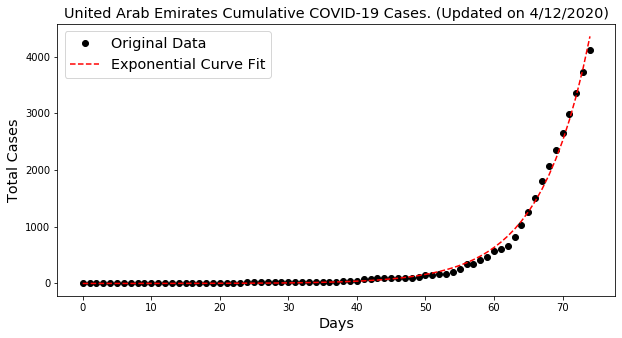



Serbia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 3630
	Confirmed cases on 4/5/2020 	 1908
	Ratio: 1.9
	Weekly increase: 90.3 %
	Daily increase: 9.6 % per day
	Doubling Time (represents recent growth): 7.5 days

** Based on Logistic Fit**

	R^2: 0.9990616699589367
	Doubling Time (during middle of growth):  7.39 (± 0.44 ) days

** Based on Exponential Fit **

	R^2: 0.9913762519480898
	Doubling Time (represents overall growth):  6.28 (± 0.51 ) days


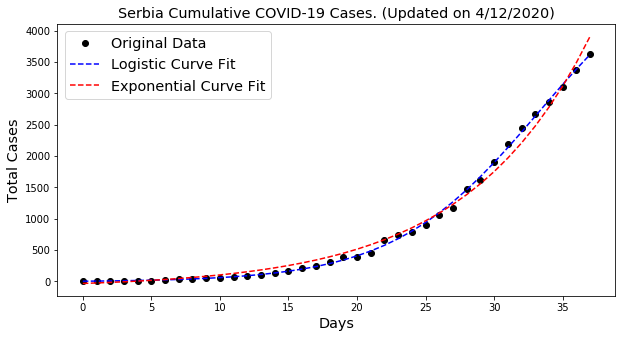



Luxembourg

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 3281
	Confirmed cases on 4/5/2020 	 2804
	Ratio: 1.17
	Weekly increase: 17.0 %
	Daily increase: 2.3 % per day
	Doubling Time (represents recent growth): 30.9 days

** Based on Logistic Fit**

	R^2: 0.9970245510068138
	Doubling Time (during middle of growth):  6.51 (± 0.51 ) days


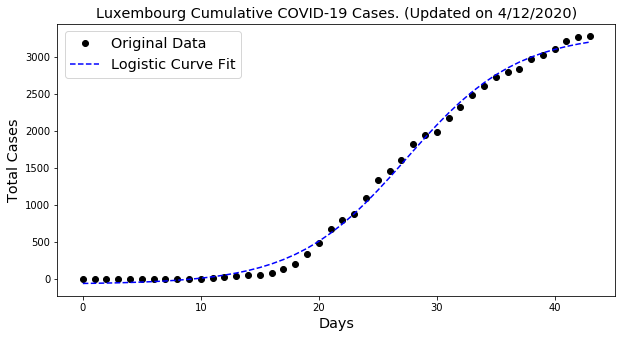



Panama

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 3234
	Confirmed cases on 4/5/2020 	 1801
	Ratio: 1.8
	Weekly increase: 79.6 %
	Daily increase: 8.7 % per day
	Doubling Time (represents recent growth): 8.3 days

** Based on Logistic Fit**

	R^2: 0.9977653195820554
	Doubling Time (during middle of growth):  11.58 (± 1.82 ) days

** Based on Exponential Fit **

	R^2: 0.9831568670862134
	Doubling Time (represents overall growth):  6.42 (± 0.83 ) days


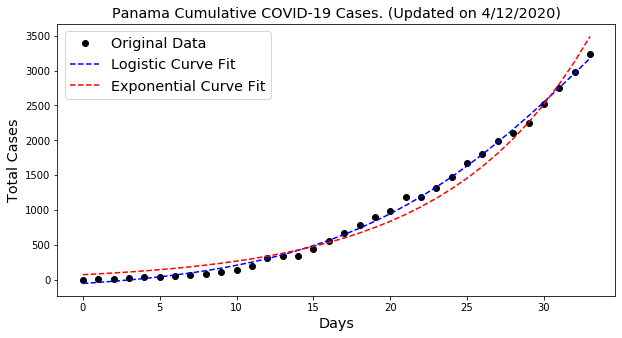



Qatar

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 2979
	Confirmed cases on 4/5/2020 	 1604
	Ratio: 1.86
	Weekly increase: 85.7 %
	Daily increase: 9.2 % per day
	Doubling Time (represents recent growth): 7.8 days

** Based on Logistic Fit**

	R^2: 0.9763361019763315
	Doubling Time (during middle of growth):  13.61 (± 6.28 ) days

** Based on Exponential Fit **

	R^2: 0.9763361036111328
	Doubling Time (represents overall growth):  6.8 (± 0.81 ) days


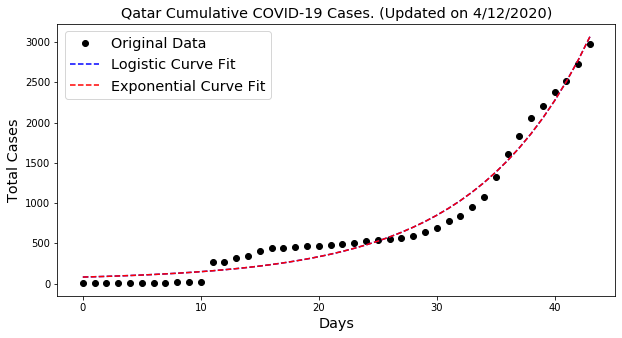



Finland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 2974
	Confirmed cases on 4/5/2020 	 1927
	Ratio: 1.54
	Weekly increase: 54.3 %
	Daily increase: 6.4 % per day
	Doubling Time (represents recent growth): 11.2 days

** Based on Logistic Fit**

	R^2: 0.9964515071123098
	Doubling Time (during middle of growth):  11.42 (± 0.87 ) days

** Based on Exponential Fit **

	R^2: 0.9887232552747729
	Doubling Time (represents overall growth):  9.46 (± 0.54 ) days


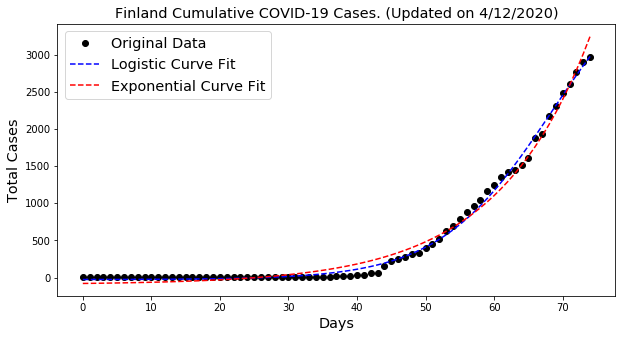



Dominican Republic

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 2967
	Confirmed cases on 4/5/2020 	 1745
	Ratio: 1.7
	Weekly increase: 70.0 %
	Daily increase: 7.9 % per day
	Doubling Time (represents recent growth): 9.1 days

** Based on Logistic Fit**

	R^2: 0.9943680757125195
	Doubling Time (during middle of growth):  8.54 (± 1.16 ) days

** Based on Exponential Fit **

	R^2: 0.9832531614501447
	Doubling Time (represents overall growth):  7.26 (± 0.78 ) days


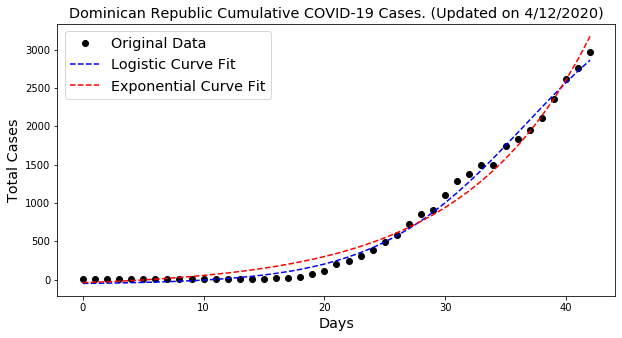



Ukraine

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 2777
	Confirmed cases on 4/5/2020 	 1308
	Ratio: 2.12
	Weekly increase: 112.3 %
	Daily increase: 11.4 % per day
	Doubling Time (represents recent growth): 6.4 days

** Based on Logistic Fit**

	R^2: 0.9931971176123549
	Doubling Time (during middle of growth):  8.9 (± 1.57 ) days

** Based on Exponential Fit **

	R^2: 0.9913949248838472
	Doubling Time (represents overall growth):  5.94 (± 0.43 ) days


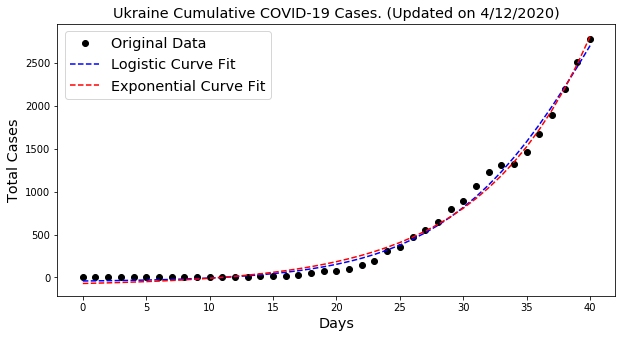



Colombia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 2776
	Confirmed cases on 4/5/2020 	 1485
	Ratio: 1.87
	Weekly increase: 86.9 %
	Daily increase: 9.3 % per day
	Doubling Time (represents recent growth): 7.8 days

** Based on Logistic Fit**

	R^2: 0.9975715964355749
	Doubling Time (during middle of growth):  11.09 (± 1.48 ) days

** Based on Exponential Fit **

	R^2: 0.9941939892812581
	Doubling Time (represents overall growth):  7.15 (± 0.51 ) days


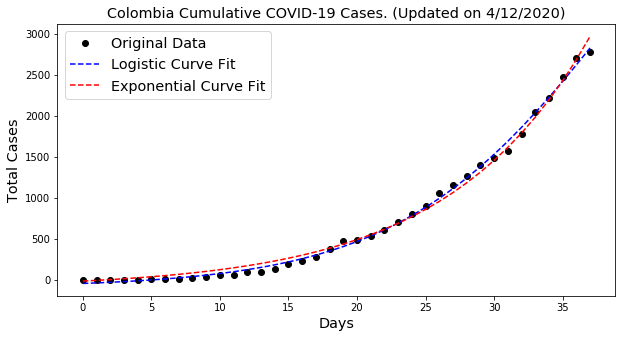



Belarus

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 2578
	Confirmed cases on 4/5/2020 	 562
	Ratio: 4.59
	Weekly increase: 358.7 %
	Daily increase: 24.3 % per day
	Doubling Time (represents recent growth): 3.2 days

** Based on Exponential Fit **

	R^2: 0.993099518533635
	Doubling Time (represents overall growth):  3.12 (± 0.16 ) days


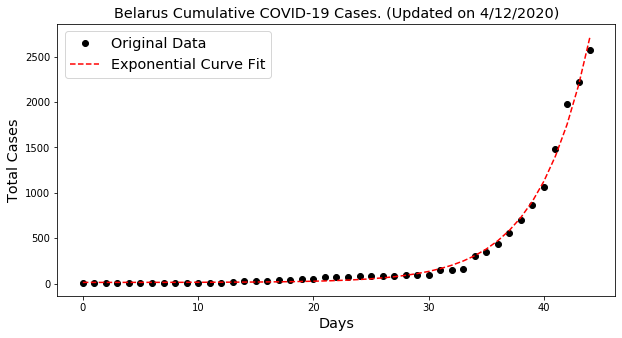



Thailand

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 2551
	Confirmed cases on 4/5/2020 	 2169
	Ratio: 1.18
	Weekly increase: 17.6 %
	Daily increase: 2.3 % per day
	Doubling Time (represents recent growth): 29.9 days

** Based on Logistic Fit**

	R^2: 0.9986813206975005
	Doubling Time (during middle of growth):  6.52 (± 0.25 ) days

** Based on Exponential Fit **

	R^2: 0.9540103719085341
	Doubling Time (represents overall growth):  10.38 (± 1.16 ) days


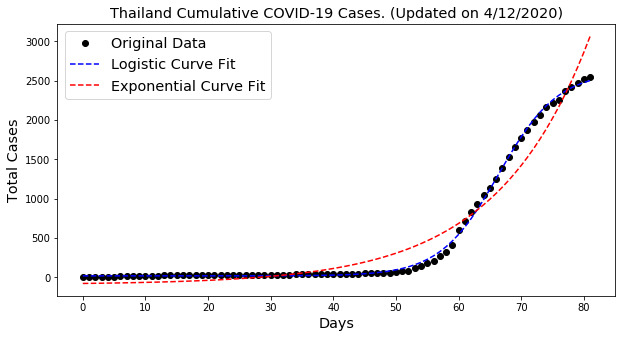



Singapore

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 2532
	Confirmed cases on 4/5/2020 	 1309
	Ratio: 1.93
	Weekly increase: 93.4 %
	Daily increase: 9.9 % per day
	Doubling Time (represents recent growth): 7.4 days

** Based on Logistic Fit**

	R^2: 0.9952345531969596
	Doubling Time (during middle of growth):  16.61 (± 0.59 ) days

** Based on Exponential Fit **

	R^2: 0.9952345532546898
	Doubling Time (represents overall growth):  8.31 (± 0.28 ) days


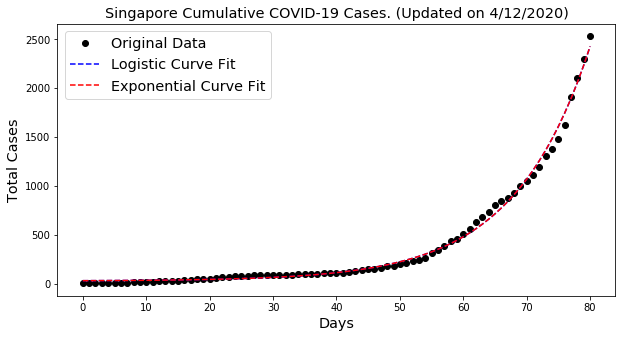



South Africa

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 2173
	Confirmed cases on 4/5/2020 	 1655
	Ratio: 1.31
	Weekly increase: 31.3 %
	Daily increase: 4.0 % per day
	Doubling Time (represents recent growth): 17.8 days

** Based on Logistic Fit**

	R^2: 0.9861578976876525
	Doubling Time (during middle of growth):  6.1 (± 1.12 ) days


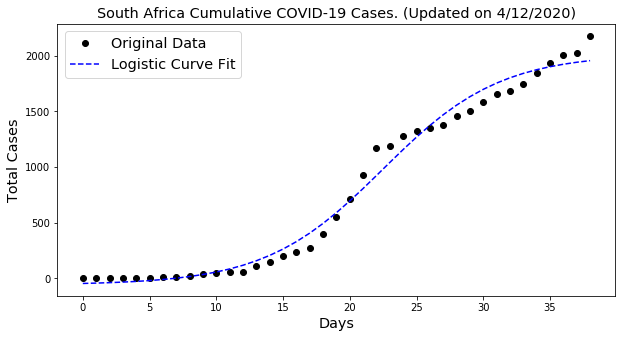



Argentina

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 2142
	Confirmed cases on 4/5/2020 	 1451
	Ratio: 1.48
	Weekly increase: 47.6 %
	Daily increase: 5.7 % per day
	Doubling Time (represents recent growth): 12.5 days

** Based on Logistic Fit**

	R^2: 0.997112765924549
	Doubling Time (during middle of growth):  7.72 (± 0.71 ) days

** Based on Exponential Fit **

	R^2: 0.9727549608179998
	Doubling Time (represents overall growth):  8.57 (± 1.38 ) days


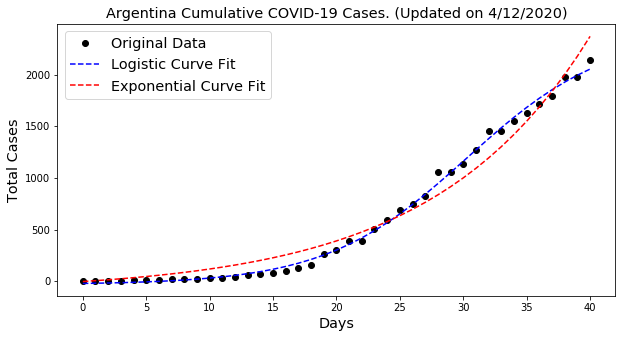



Greece

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 2114
	Confirmed cases on 4/5/2020 	 1735
	Ratio: 1.22
	Weekly increase: 21.8 %
	Daily increase: 2.9 % per day
	Doubling Time (represents recent growth): 24.6 days

** Based on Logistic Fit**

	R^2: 0.9987367243105929
	Doubling Time (during middle of growth):  10.23 (± 0.61 ) days

** Based on Exponential Fit **

	R^2: 0.951634765237501
	Doubling Time (represents overall growth):  9.81 (± 1.95 ) days


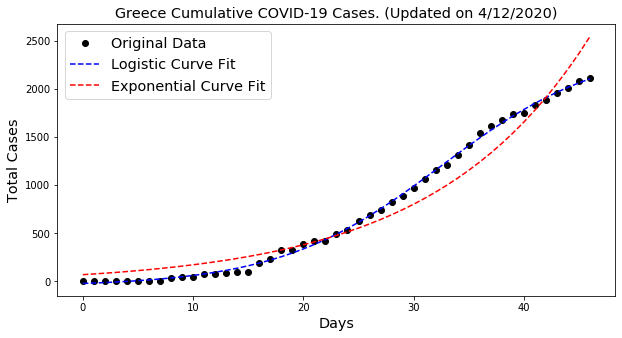



Egypt

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 2065
	Confirmed cases on 4/5/2020 	 1173
	Ratio: 1.76
	Weekly increase: 76.0 %
	Daily increase: 8.4 % per day
	Doubling Time (represents recent growth): 8.6 days

** Based on Logistic Fit**

	R^2: 0.9982905462407616
	Doubling Time (during middle of growth):  13.36 (± 1.01 ) days

** Based on Exponential Fit **

	R^2: 0.9974301539908103
	Doubling Time (represents overall growth):  8.19 (± 0.26 ) days


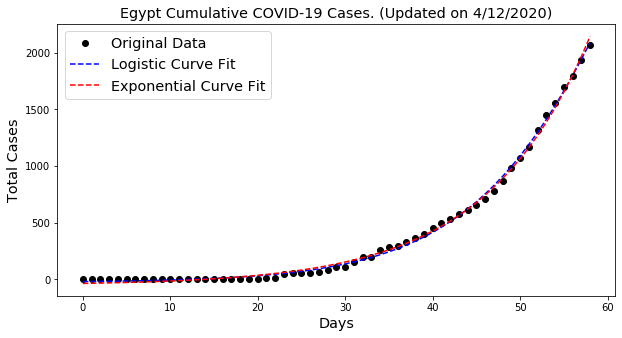



Algeria

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 1914
	Confirmed cases on 4/5/2020 	 1320
	Ratio: 1.45
	Weekly increase: 45.0 %
	Daily increase: 5.5 % per day
	Doubling Time (represents recent growth): 13.1 days

** Based on Logistic Fit**

	R^2: 0.9982909472157339
	Doubling Time (during middle of growth):  6.57 (± 0.4 ) days

** Based on Exponential Fit **

	R^2: 0.9768829394430619
	Doubling Time (represents overall growth):  8.13 (± 0.96 ) days


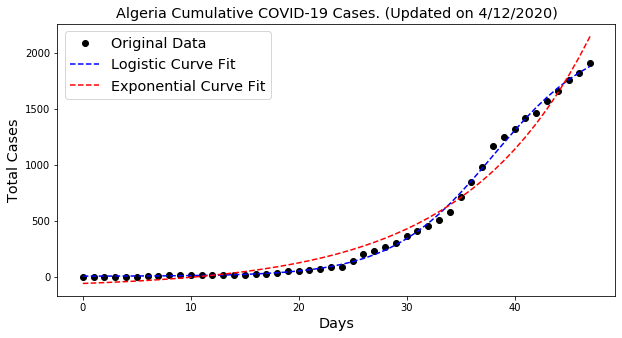



Iceland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 1701
	Confirmed cases on 4/5/2020 	 1486
	Ratio: 1.14
	Weekly increase: 14.5 %
	Daily increase: 1.9 % per day
	Doubling Time (represents recent growth): 35.9 days

** Based on Logistic Fit**

	R^2: 0.9990718154854118
	Doubling Time (during middle of growth):  8.27 (± 0.39 ) days


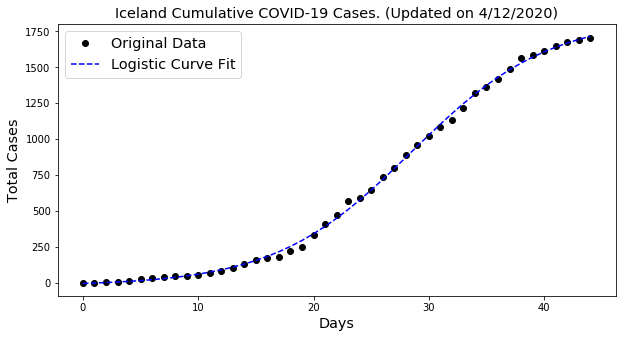



Moldova

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 1662
	Confirmed cases on 4/5/2020 	 864
	Ratio: 1.92
	Weekly increase: 92.4 %
	Daily increase: 9.8 % per day
	Doubling Time (represents recent growth): 7.4 days

** Based on Logistic Fit**

	R^2: 0.998792488242964
	Doubling Time (during middle of growth):  6.85 (± 0.48 ) days

** Based on Exponential Fit **

	R^2: 0.9922680379643127
	Doubling Time (represents overall growth):  6.25 (± 0.5 ) days


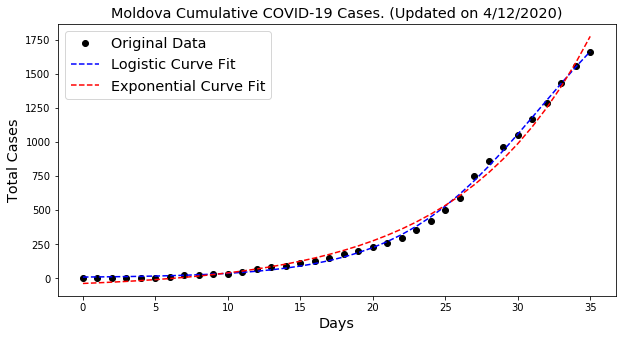



Morocco

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 1661
	Confirmed cases on 4/5/2020 	 1021
	Ratio: 1.63
	Weekly increase: 62.7 %
	Daily increase: 7.2 % per day
	Doubling Time (represents recent growth): 10.0 days

** Based on Logistic Fit**

	R^2: 0.9984829549117072
	Doubling Time (during middle of growth):  8.01 (± 0.55 ) days

** Based on Exponential Fit **

	R^2: 0.9877704784417791
	Doubling Time (represents overall growth):  7.89 (± 0.76 ) days


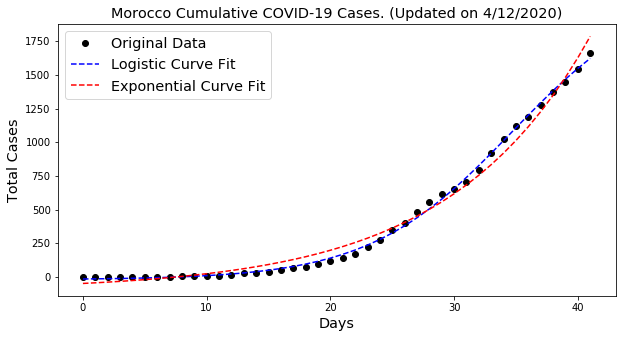



Croatia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 1600
	Confirmed cases on 4/5/2020 	 1182
	Ratio: 1.35
	Weekly increase: 35.4 %
	Daily increase: 4.4 % per day
	Doubling Time (represents recent growth): 16.0 days

** Based on Logistic Fit**

	R^2: 0.9971907031063821
	Doubling Time (during middle of growth):  7.39 (± 0.56 ) days

** Based on Exponential Fit **

	R^2: 0.9667989393366194
	Doubling Time (represents overall growth):  9.83 (± 1.58 ) days


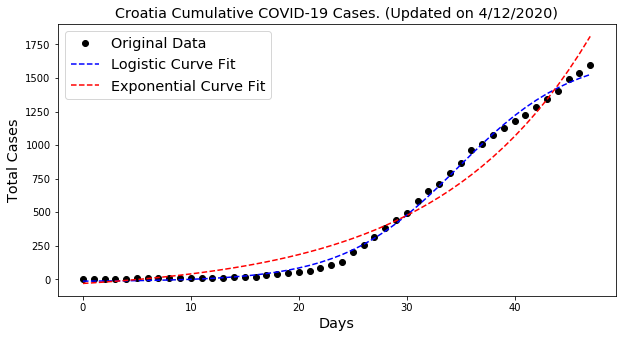



Hungary

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 1410
	Confirmed cases on 4/5/2020 	 733
	Ratio: 1.92
	Weekly increase: 92.4 %
	Daily increase: 9.8 % per day
	Doubling Time (represents recent growth): 7.4 days

** Based on Logistic Fit**

	R^2: 0.9932065913986095
	Doubling Time (during middle of growth):  16.09 (± 5.33 ) days

** Based on Exponential Fit **

	R^2: 0.9932065921659162
	Doubling Time (represents overall growth):  8.04 (± 0.61 ) days


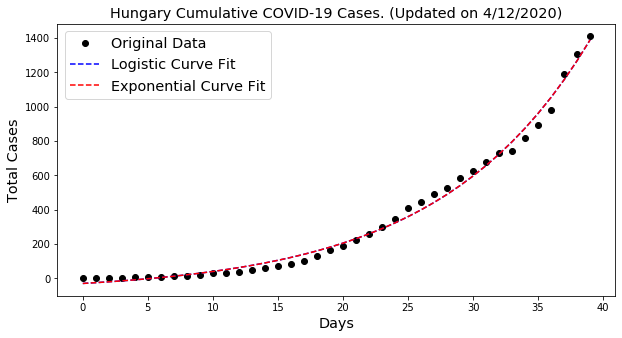



Iraq

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 1352
	Confirmed cases on 4/5/2020 	 961
	Ratio: 1.41
	Weekly increase: 40.7 %
	Daily increase: 5.0 % per day
	Doubling Time (represents recent growth): 14.2 days

** Based on Logistic Fit**

	R^2: 0.9987248100201493
	Doubling Time (during middle of growth):  9.86 (± 0.59 ) days

** Based on Exponential Fit **

	R^2: 0.9893538596597009
	Doubling Time (represents overall growth):  10.51 (± 0.94 ) days


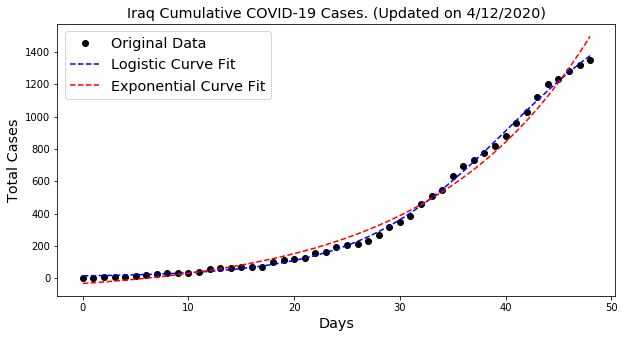



New Zealand

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 1330
	Confirmed cases on 4/5/2020 	 1039
	Ratio: 1.28
	Weekly increase: 28.0 %
	Daily increase: 3.6 % per day
	Doubling Time (represents recent growth): 19.7 days

** Based on Logistic Fit**

	R^2: 0.9984150951858267
	Doubling Time (during middle of growth):  5.62 (± 0.32 ) days

** Based on Exponential Fit **

	R^2: 0.9566361933631906
	Doubling Time (represents overall growth):  8.77 (± 1.62 ) days


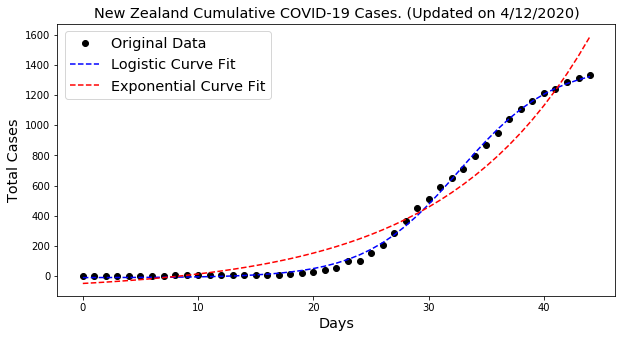



Estonia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 1309
	Confirmed cases on 4/5/2020 	 1097
	Ratio: 1.19
	Weekly increase: 19.3 %
	Daily increase: 2.6 % per day
	Doubling Time (represents recent growth): 27.5 days

** Based on Logistic Fit**

	R^2: 0.995436719757338
	Doubling Time (during middle of growth):  10.29 (± 1.22 ) days

** Based on Exponential Fit **

	R^2: 0.9709387713788779
	Doubling Time (represents overall growth):  11.17 (± 1.92 ) days


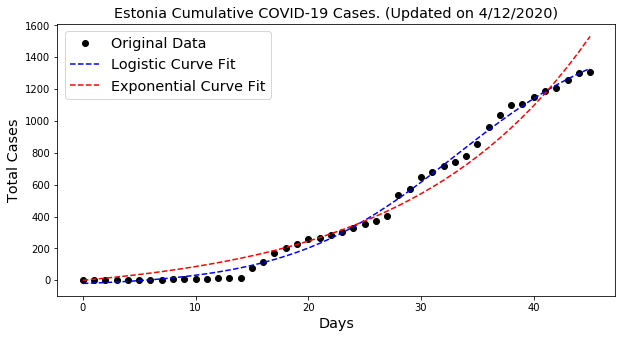



Kuwait

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 1234
	Confirmed cases on 4/5/2020 	 556
	Ratio: 2.22
	Weekly increase: 121.9 %
	Daily increase: 12.1 % per day
	Doubling Time (represents recent growth): 6.1 days

** Based on Logistic Fit**

	R^2: 0.9917929634054761
	Doubling Time (during middle of growth):  11.33 (± 0.68 ) days

** Based on Exponential Fit **

	R^2: 0.9917929634340784
	Doubling Time (represents overall growth):  5.66 (± 0.33 ) days


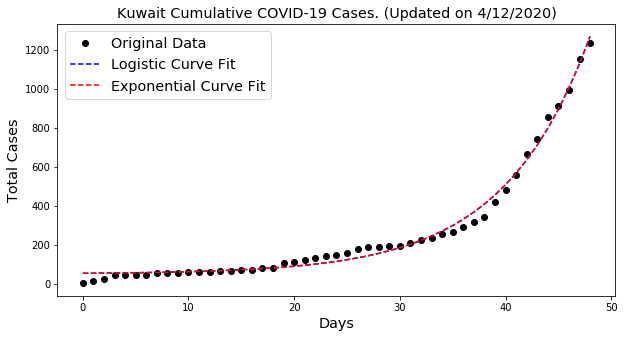



Slovenia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 1205
	Confirmed cases on 4/5/2020 	 997
	Ratio: 1.21
	Weekly increase: 20.9 %
	Daily increase: 2.7 % per day
	Doubling Time (represents recent growth): 25.6 days

** Based on Logistic Fit**

	R^2: 0.9980867642622155
	Doubling Time (during middle of growth):  13.16 (± 1.61 ) days


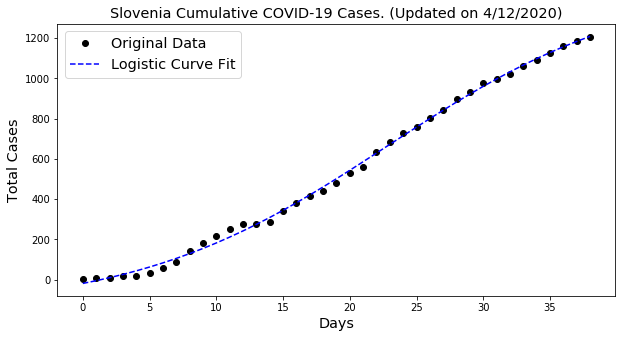



Bahrain

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 1136
	Confirmed cases on 4/5/2020 	 700
	Ratio: 1.62
	Weekly increase: 62.3 %
	Daily increase: 7.2 % per day
	Doubling Time (represents recent growth): 10.0 days

** Based on Logistic Fit**

	R^2: 0.9941579989724392
	Doubling Time (during middle of growth):  30.85 (± nan ) days

** Based on Exponential Fit **

	R^2: 0.9929906192148805
	Doubling Time (represents overall growth):  13.56 (± 1.17 ) days


C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in sqrt


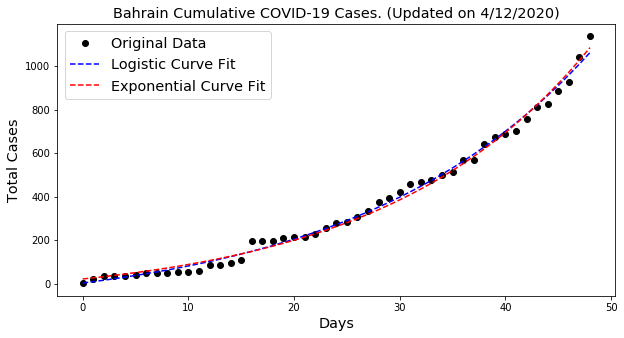



Azerbaijan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 1098
	Confirmed cases on 4/5/2020 	 584
	Ratio: 1.88
	Weekly increase: 88.0 %
	Daily increase: 9.4 % per day
	Doubling Time (represents recent growth): 7.7 days

** Based on Logistic Fit**

	R^2: 0.9990472706112202
	Doubling Time (during middle of growth):  7.35 (± 0.4 ) days

** Based on Exponential Fit **

	R^2: 0.9914668896135651
	Doubling Time (represents overall growth):  6.47 (± 0.46 ) days


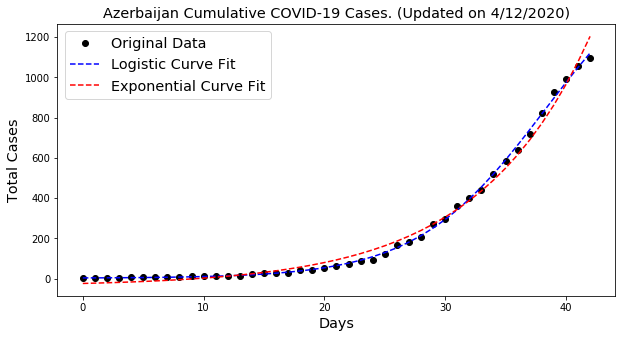



Lithuania

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 1053
	Confirmed cases on 4/5/2020 	 811
	Ratio: 1.3
	Weekly increase: 29.8 %
	Daily increase: 3.8 % per day
	Doubling Time (represents recent growth): 18.6 days

** Based on Logistic Fit**

	R^2: 0.9975839791103581
	Doubling Time (during middle of growth):  6.86 (± 0.5 ) days

** Based on Exponential Fit **

	R^2: 0.9661645668154691
	Doubling Time (represents overall growth):  9.88 (± 1.72 ) days


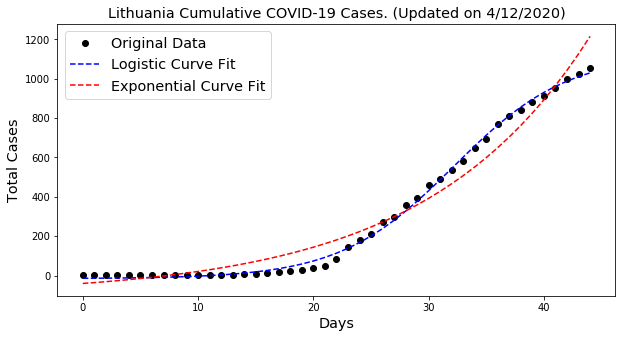



Armenia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 1013
	Confirmed cases on 4/5/2020 	 822
	Ratio: 1.23
	Weekly increase: 23.2 %
	Daily increase: 3.0 % per day
	Doubling Time (represents recent growth): 23.2 days

** Based on Logistic Fit**

	R^2: 0.9976279702404626
	Doubling Time (during middle of growth):  7.65 (± 0.59 ) days

** Based on Exponential Fit **

	R^2: 0.9683048629307156
	Doubling Time (represents overall growth):  10.59 (± 1.99 ) days


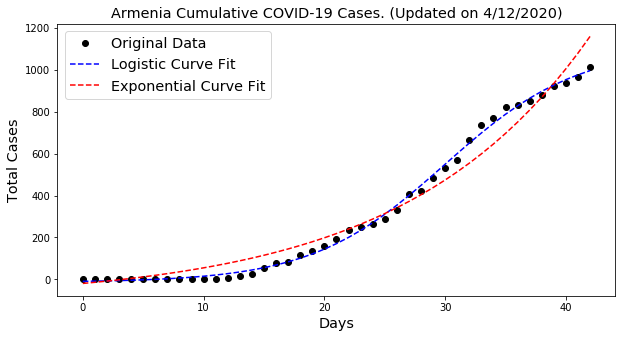



Bosnia and Herzegovina

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 1009
	Confirmed cases on 4/5/2020 	 654
	Ratio: 1.54
	Weekly increase: 54.3 %
	Daily increase: 6.4 % per day
	Doubling Time (represents recent growth): 11.2 days

** Based on Logistic Fit**

	R^2: 0.9983859357987802
	Doubling Time (during middle of growth):  8.34 (± 0.64 ) days

** Based on Exponential Fit **

	R^2: 0.9871580425855954
	Doubling Time (represents overall growth):  9.31 (± 1.12 ) days


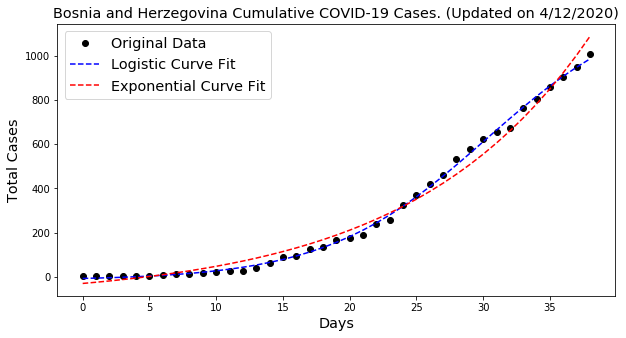

In [5]:
topcountries = cases.index
inferreddoublingtime = []
recentdoublingtime = []
errors = []
countries = []
print('\n')

for c in topcountries:
    print(c)
    a = plotCases(df, 'Country/Region', c)
    if a:
        countries.append(c)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

Now we've plotted the trends for all nations with more than 1,000 cases as of April 12th. The U.S. still appears to be on an exponential trend, while Italy and Spain seem to be coming out of it. This should make sense, seeing as Italy's and Spain's lockdowns were more aggressive than the United States.

These two European nations have also started their lockdowns early, with Italy and Spain beginning their lockdowns on March 9th and 14th, respectively. Lockdowns within the U.S. vary by state; however, the most highly impacted states (California and New York) didn't institute any lockdowns until the last week of March.

Considering the recent spike in cases in France, our program couldn't really tell if the trend was exponential or logistic. As a result, both trends were plotted. Today, more than 500 people died in France in a single day, which prompted the government to [extend the lockdowns until May 11](https://www.trtworld.com/life/france-extends-virus-lockdown-as-death-toll-nears-15-000-latest-updates-35348).

China is also currently experiencing a logistic trend. With the exception for the Guangdong province, the nation has not recorded any new cases in any of its provinces since April 7th. China has not had a consistent and reliable metric of [reporting GDP figures](https://www.bbc.com/news/business-38686570). For the same reason, people are more or less skeptical of the integrity of their COVID-19 cases.

### Doubling Times for COVID-19 Cases

Now we're going to plot the inferred doubling times and recent doubling times for all countries in one chart. We've already calculated this previously. The inferred doubling times are constructed using curve fits. In contrast, the recent doubling times are calculated using the most recent week of data. Obviously, the shorter amount of time it takes for cases to double, the faster overall cases grow, and vice versa.

    Inferred Doubling Time  95%CI  Recent Doubling Time
0                      7.0    0.2                   9.7
1                      7.2    0.2                  20.5
2                      9.5    0.4                  25.2
3                      7.7    0.2                  19.8
4                      9.6    1.0                   9.1
..                     ...    ...                   ...
65                    13.6    1.2                  10.0
66                     7.3    0.4                   7.7
67                     6.9    0.5                  18.6
68                     7.6    0.6                  23.2
69                     8.3    0.6                  11.2

[70 rows x 3 columns]




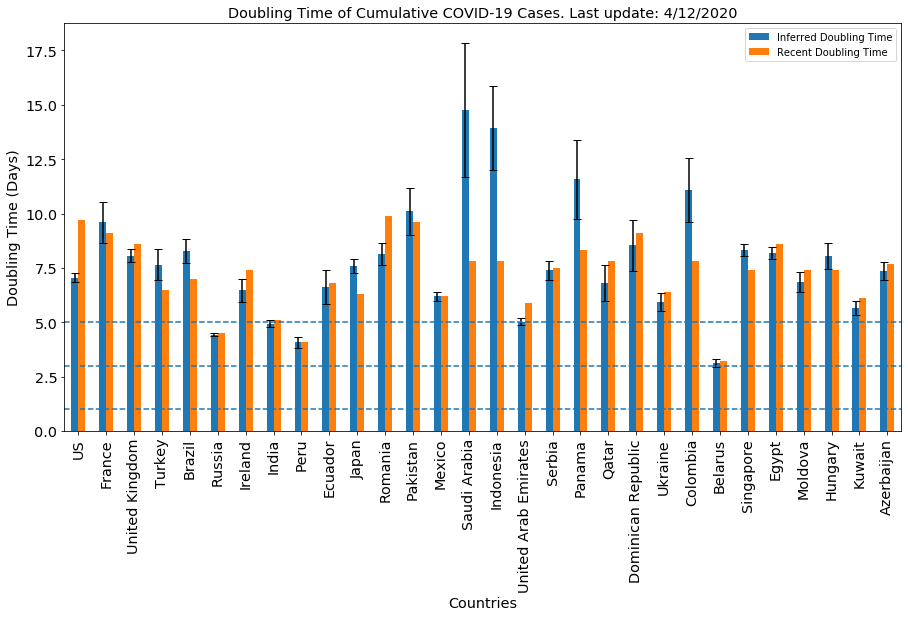

In [6]:
d = {'Countries': countries, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print(pd.DataFrame(data=d).iloc[:,[1,2,3]].round(1))    

err = pd.DataFrame([errors,[float('NaN') for e in errors]]).T
err.index=countries
err.columns = ['Inferred Doubling Time', 'Recent Doubling Time']

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 10]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

The inferred doubling time represents the growth encountered during the middle of the growth of the epidemic, which gives us a picture of the overall rate of growth of the virus. After all, epidemiologist won't really know whether or not we've reached the apex of the pandemic until many weeks (or possibly months). In one country that reports 1,000 COVID-19 cases, there could be 5,000 infected people. On the other hand, another country with the same reported figures could have 100,000 infected people.

As mentioned previously, the growth rate in the U.S. is still exponential, and the inferred doubling time is around 7 days. For France, the doubling time is approximately 10 days. Obviously, the high the doubling rate, the more manageable the pandemic is for any particular country. There are very few countries within the error range that we have established.

### COVID-19 Trends in the United States

I've done many comparisons with the U.S. (mostly because I currently live in the U.S.). We can extend the same analysis to areas within the country. This time, we will be using a different dataset, which only incorporates the U.S. We will also need to create a dictionary of all 50 states.


In [7]:
df = pd.read_csv('time_series_covid19_confirmed_US_2.csv')

uscases = df[df['Country/Region'] == 'US'].copy()

states = { 'AK': 'Alaska', 'AL': 'Alabama', 'AR': 'Arkansas', 'AS': 'American Samoa', 'AZ': 'Arizona', 'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DC': 'District of Columbia', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 'GU': 'Guam', 'HI': 'Hawaii', 'IA': 'Iowa', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'MA': 'Massachusetts', 'MD': 'Maryland', 'ME': 'Maine', 'MI': 'Michigan', 'MN': 'Minnesota', 'MO': 'Missouri', 'MP': 'Northern Mariana Islands', 'MS': 'Mississippi', 'MT': 'Montana', 'NA': 'National', 'NC': 'North Carolina', 'ND': 'North Dakota', 'NE': 'Nebraska', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NV': 'Nevada', 'NY': 'New York', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'PR': 'Puerto Rico', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VA': 'Virginia', 'VI': 'Virgin Islands', 'VT': 'Vermont', 'WA': 'Washington', 'WI': 'Wisconsin', 'WV': 'West Virginia', 'WY': 'Wyoming', 'D.C.': 'District of Columbia'}

for index, row in uscases.iterrows():
    location = row['Province/State']
    try:
        if ',' in location:
            result = [x.strip() for x in location.split(',')]
            statename = states[result[1]]
            row['State'] = statename
            uscases.loc[index, 'Province/State'] = statename
    except:
        print('Error parsing US state:', location)        
            
usstatesummary = uscases.iloc[:,[0,-1]].groupby('Province/State').sum()
mostrecentdate = usstatesummary.columns[0]
usstatesummary = usstatesummary.sort_values(by = mostrecentdate, ascending = False)
usstatesummary = usstatesummary[usstatesummary[mostrecentdate] > 0]

print('\nNumber of confirmed US COVID-19 cases by state as of', mostrecentdate)
usstatesummary.head(10)


Number of confirmed US COVID-19 cases by state as of 4/12/2020


4/12/2020
Province/State           
New York           189033
New Jersey          61850
Massachusetts       25475
Michigan            24244
Pennsylvania        22938
California          22795
Illinois            20852
Louisiana           20595
Florida             19895
Texas               13677

As we can see, New York has the largest number of confirmed cases in the entire nation; followed by New Jersey, Massachusetts, and then Michigan. Now we can plot the trends for each state with more than 100 cases.

                      4/12/2020
Province/State                 
New York                 189033
New Jersey                61850
Massachusetts             25475
Michigan                  24244
Pennsylvania              22938
California                22795
Illinois                  20852
Louisiana                 20595
Florida                   19895
Texas                     13677
Georgia                   12452
Connecticut               12035
Washington                10609
Maryland                   8225
Indiana                    7928
Colorado                   7307
Ohio                       6604
Tennessee                  5508
Virginia                   5274
North Carolina             4570
Missouri                   4269
Alabama                    3563
Arizona                    3542
Wisconsin                  3341
South Carolina             3320
Nevada                     2836
Mississippi                2781
Rhode Island               2665
Utah                       2303
Oklahoma

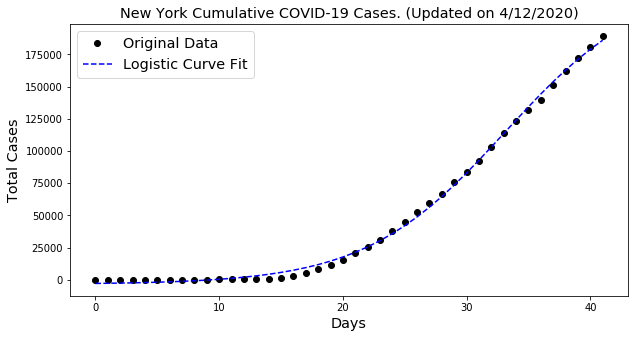



US state:  New Jersey

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 61850
	Confirmed cases on 4/5/2020 	 37505
	Ratio: 1.65
	Weekly increase: 64.9 %
	Daily increase: 7.4 % per day
	Doubling Time (represents recent growth): 9.7 days

** Based on Logistic Fit**

	R^2: 0.9989512236868626
	Doubling Time (during middle of growth):  6.23 (± 0.34 ) days


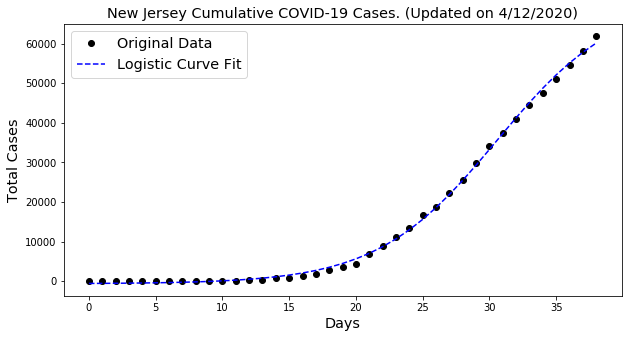



US state:  Massachusetts

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 25475
	Confirmed cases on 4/5/2020 	 12500
	Ratio: 2.04
	Weekly increase: 103.8 %
	Daily increase: 10.7 % per day
	Doubling Time (represents recent growth): 6.8 days

** Based on Logistic Fit**

	R^2: 0.997143159912647
	Doubling Time (during middle of growth):  7.57 (± 0.51 ) days

** Based on Exponential Fit **

	R^2: 0.9894260772030039
	Doubling Time (represents overall growth):  5.73 (± 0.3 ) days


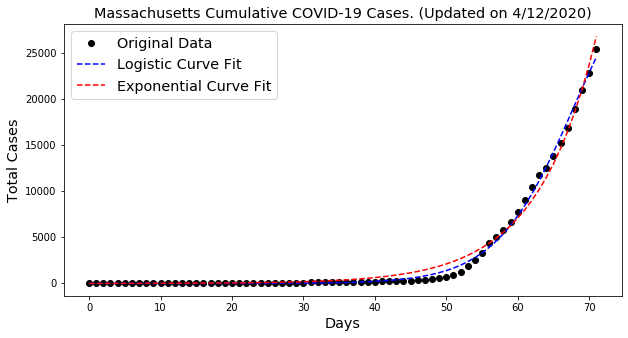



US state:  Michigan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 24244
	Confirmed cases on 4/5/2020 	 15718
	Ratio: 1.54
	Weekly increase: 54.2 %
	Daily increase: 6.4 % per day
	Doubling Time (represents recent growth): 11.2 days

** Based on Logistic Fit**

	R^2: 0.9997913117717506
	Doubling Time (during middle of growth):  5.8 (± 0.16 ) days


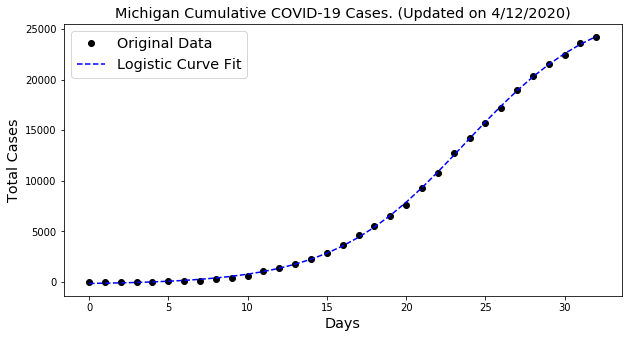



US state:  Pennsylvania

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 22938
	Confirmed cases on 4/5/2020 	 11589
	Ratio: 1.98
	Weekly increase: 97.9 %
	Daily increase: 10.2 % per day
	Doubling Time (represents recent growth): 7.1 days

** Based on Logistic Fit**

	R^2: 0.9997304632562146
	Doubling Time (during middle of growth):  6.19 (± 0.18 ) days

** Based on Exponential Fit **

	R^2: 0.9719922484119466
	Doubling Time (represents overall growth):  4.59 (± 0.59 ) days


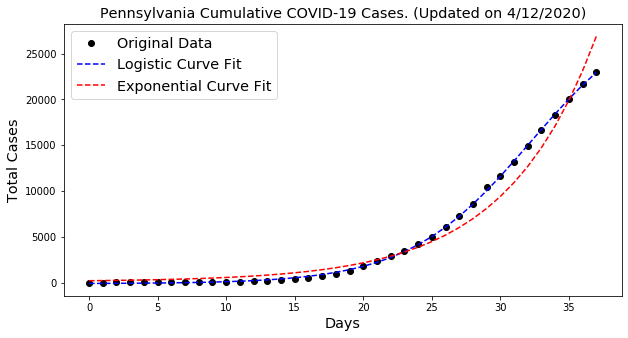



US state:  California

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 22795
	Confirmed cases on 4/5/2020 	 15034
	Ratio: 1.52
	Weekly increase: 51.6 %
	Daily increase: 6.1 % per day
	Doubling Time (represents recent growth): 11.7 days

** Based on Logistic Fit**

	R^2: 0.9997443913506612
	Doubling Time (during middle of growth):  6.92 (± 0.13 ) days

** Based on Exponential Fit **

	R^2: 0.9804277648904178
	Doubling Time (represents overall growth):  6.84 (± 0.47 ) days


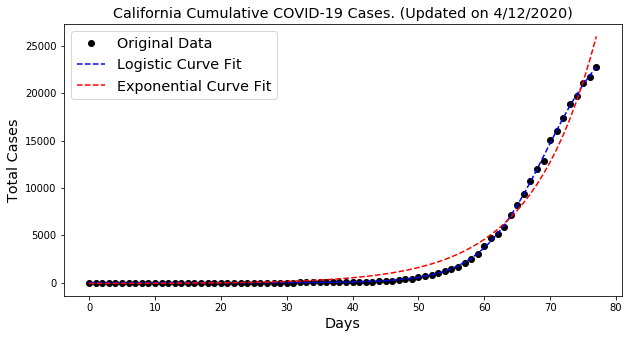



US state:  Illinois

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 20852
	Confirmed cases on 4/5/2020 	 11259
	Ratio: 1.85
	Weekly increase: 85.2 %
	Daily increase: 9.2 % per day
	Doubling Time (represents recent growth): 7.9 days

** Based on Logistic Fit**

	R^2: 0.9990489752894463
	Doubling Time (during middle of growth):  7.32 (± 0.26 ) days

** Based on Exponential Fit **

	R^2: 0.9884749973778268
	Doubling Time (represents overall growth):  6.05 (± 0.31 ) days


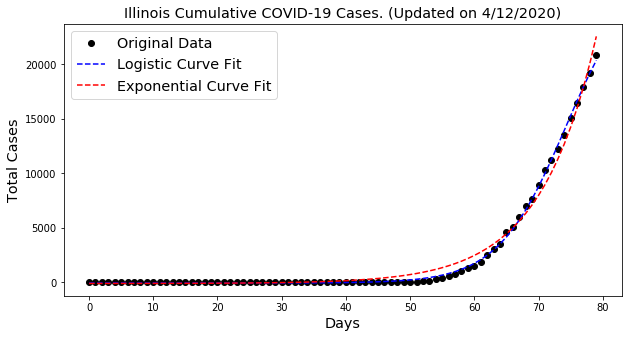



US state:  Louisiana

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 20595
	Confirmed cases on 4/5/2020 	 13010
	Ratio: 1.58
	Weekly increase: 58.3 %
	Daily increase: 6.8 % per day
	Doubling Time (represents recent growth): 10.6 days

** Based on Logistic Fit**

	R^2: 0.9978534753020707
	Doubling Time (during middle of growth):  4.87 (± 0.4 ) days


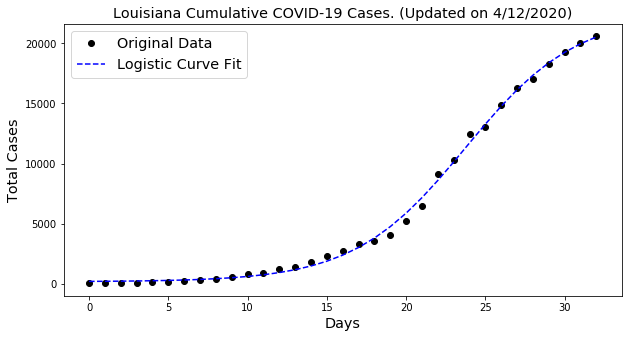



US state:  Florida

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 19895
	Confirmed cases on 4/5/2020 	 12350
	Ratio: 1.61
	Weekly increase: 61.1 %
	Daily increase: 7.0 % per day
	Doubling Time (represents recent growth): 10.2 days

** Based on Logistic Fit**

	R^2: 0.998577794461992
	Doubling Time (during middle of growth):  6.13 (± 0.37 ) days


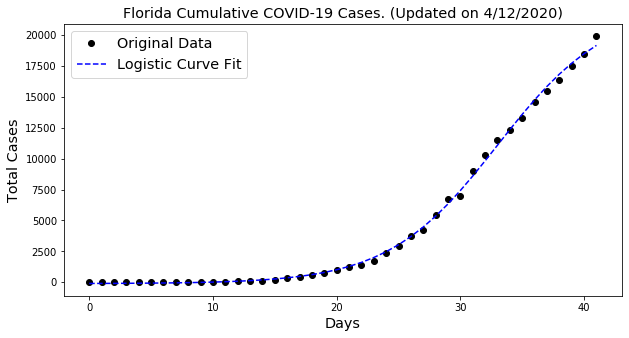



US state:  Texas

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 13677
	Confirmed cases on 4/5/2020 	 7209
	Ratio: 1.9
	Weekly increase: 89.7 %
	Daily increase: 9.6 % per day
	Doubling Time (represents recent growth): 7.6 days

** Based on Logistic Fit**

	R^2: 0.9992755001117193
	Doubling Time (during middle of growth):  7.72 (± 0.41 ) days

** Based on Exponential Fit **

	R^2: 0.979387320487994
	Doubling Time (represents overall growth):  5.21 (± 0.59 ) days


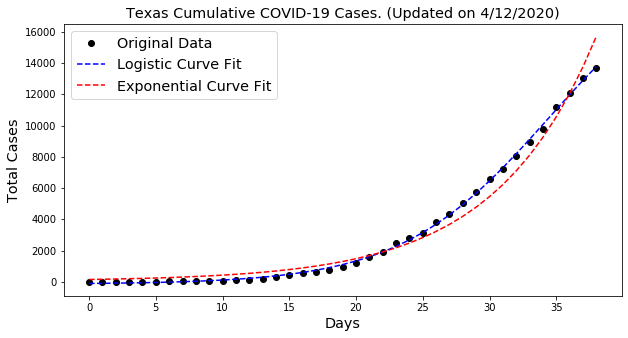



US state:  Georgia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 12452
	Confirmed cases on 4/5/2020 	 6647
	Ratio: 1.87
	Weekly increase: 87.3 %
	Daily increase: 9.4 % per day
	Doubling Time (represents recent growth): 7.7 days

** Based on Logistic Fit**

	R^2: 0.9973527434586087
	Doubling Time (during middle of growth):  7.39 (± 0.68 ) days

** Based on Exponential Fit **

	R^2: 0.97662963594321
	Doubling Time (represents overall growth):  5.56 (± 0.65 ) days


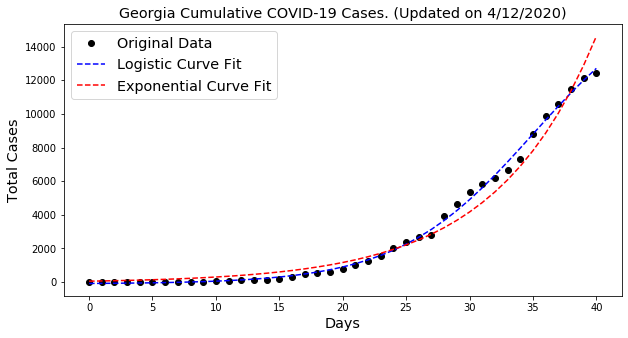



US state:  Connecticut

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 12035
	Confirmed cases on 4/5/2020 	 5675
	Ratio: 2.12
	Weekly increase: 112.1 %
	Daily increase: 11.3 % per day
	Doubling Time (represents recent growth): 6.5 days

** Based on Logistic Fit**

	R^2: 0.9969994208252144
	Doubling Time (during middle of growth):  7.46 (± 0.91 ) days

** Based on Exponential Fit **

	R^2: 0.9714971136982524
	Doubling Time (represents overall growth):  4.64 (± 0.67 ) days


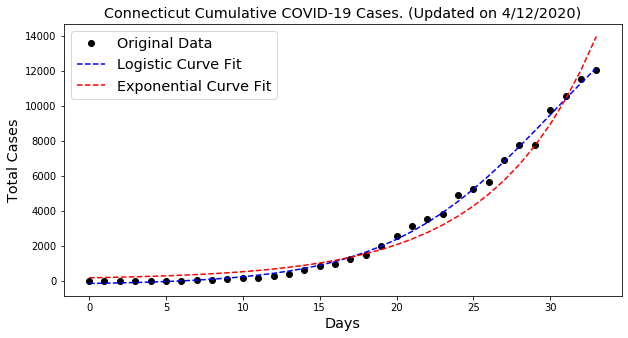



US state:  Washington

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 10609
	Confirmed cases on 4/5/2020 	 7825
	Ratio: 1.36
	Weekly increase: 35.6 %
	Daily increase: 4.4 % per day
	Doubling Time (represents recent growth): 15.9 days

** Based on Logistic Fit**

	R^2: 0.9995045268213648
	Doubling Time (during middle of growth):  8.95 (± 0.22 ) days

** Based on Exponential Fit **

	R^2: 0.980404524036894
	Doubling Time (represents overall growth):  8.74 (± 0.61 ) days


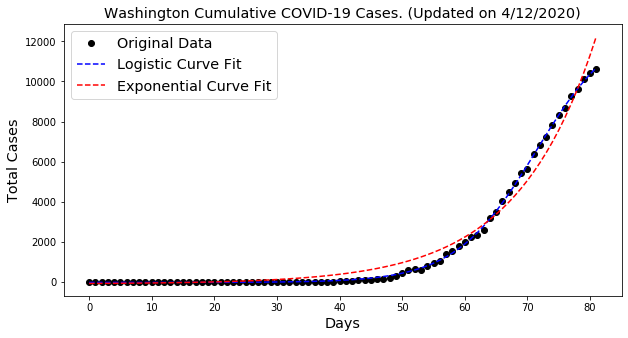



US state:  Maryland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 8225
	Confirmed cases on 4/5/2020 	 3617
	Ratio: 2.27
	Weekly increase: 127.4 %
	Daily increase: 12.5 % per day
	Doubling Time (represents recent growth): 5.9 days

** Based on Logistic Fit**

	R^2: 0.9985756504174114
	Doubling Time (during middle of growth):  7.48 (± 0.58 ) days

** Based on Exponential Fit **

	R^2: 0.993998853931691
	Doubling Time (represents overall growth):  5.19 (± 0.32 ) days


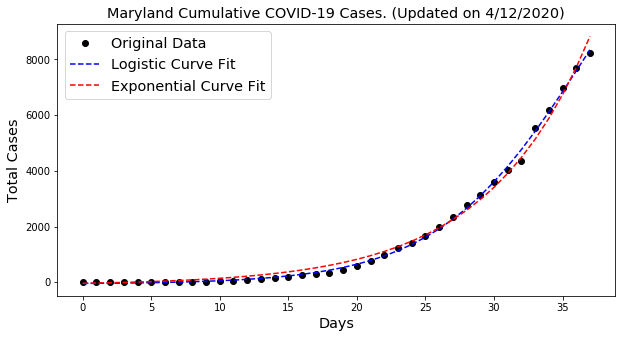



US state:  Indiana

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 7928
	Confirmed cases on 4/5/2020 	 4411
	Ratio: 1.8
	Weekly increase: 79.7 %
	Daily increase: 8.7 % per day
	Doubling Time (represents recent growth): 8.3 days

** Based on Logistic Fit**

	R^2: 0.9990385232552843
	Doubling Time (during middle of growth):  6.3 (± 0.34 ) days

** Based on Exponential Fit **

	R^2: 0.9764411984139704
	Doubling Time (represents overall growth):  5.69 (± 0.74 ) days


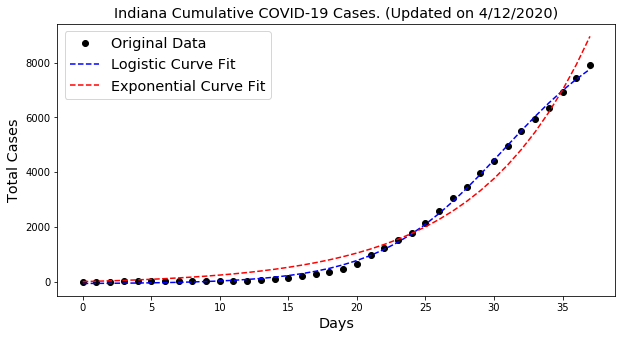



US state:  Colorado

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 7307
	Confirmed cases on 4/5/2020 	 4950
	Ratio: 1.48
	Weekly increase: 47.6 %
	Daily increase: 5.7 % per day
	Doubling Time (represents recent growth): 12.5 days

** Based on Logistic Fit**

	R^2: 0.9983419130014997
	Doubling Time (during middle of growth):  7.38 (± 0.53 ) days


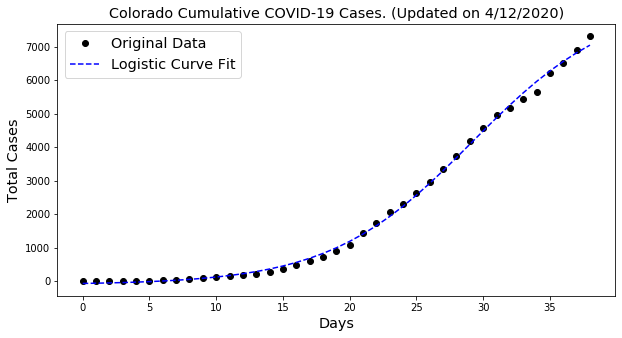



US state:  Ohio

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 6604
	Confirmed cases on 4/5/2020 	 4043
	Ratio: 1.63
	Weekly increase: 63.3 %
	Daily increase: 7.3 % per day
	Doubling Time (represents recent growth): 9.9 days

** Based on Logistic Fit**

	R^2: 0.9993842211830114
	Doubling Time (during middle of growth):  7.1 (± 0.36 ) days


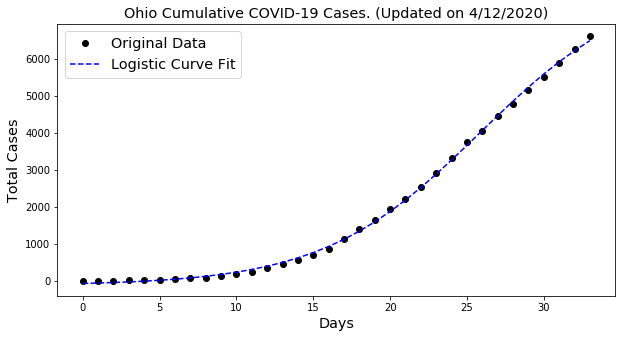



US state:  Tennessee

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 5508
	Confirmed cases on 4/5/2020 	 3633
	Ratio: 1.52
	Weekly increase: 51.6 %
	Daily increase: 6.1 % per day
	Doubling Time (represents recent growth): 11.7 days

** Based on Logistic Fit**

	R^2: 0.9962495252709289
	Doubling Time (during middle of growth):  7.37 (± 0.79 ) days


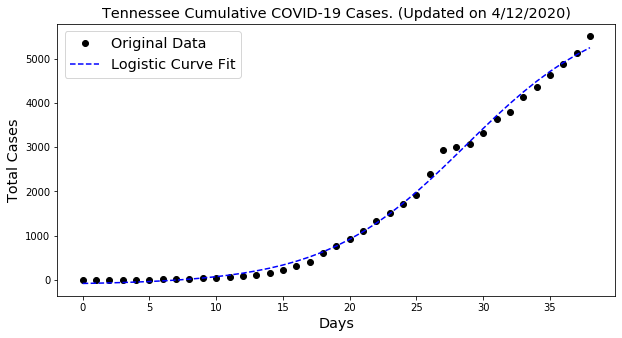



US state:  Virginia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 5274
	Confirmed cases on 4/5/2020 	 2640
	Ratio: 2.0
	Weekly increase: 99.8 %
	Daily increase: 10.4 % per day
	Doubling Time (represents recent growth): 7.0 days

** Based on Logistic Fit**

	R^2: 0.999160233096237
	Doubling Time (during middle of growth):  7.4 (± 0.45 ) days

** Based on Exponential Fit **

	R^2: 0.9915672967513884
	Doubling Time (represents overall growth):  5.76 (± 0.47 ) days


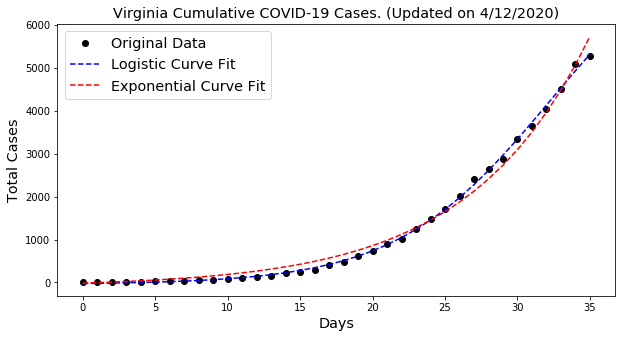



US state:  North Carolina

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 4570
	Confirmed cases on 4/5/2020 	 2649
	Ratio: 1.73
	Weekly increase: 72.5 %
	Daily increase: 8.1 % per day
	Doubling Time (represents recent growth): 8.9 days

** Based on Logistic Fit**

	R^2: 0.9990959923186404
	Doubling Time (during middle of growth):  7.95 (± 0.44 ) days

** Based on Exponential Fit **

	R^2: 0.9847028324616213
	Doubling Time (represents overall growth):  6.9 (± 0.73 ) days


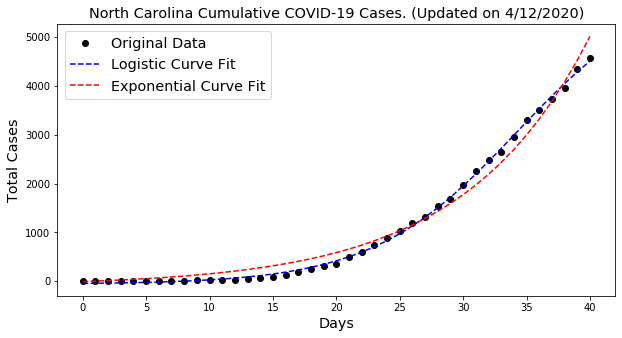



US state:  Missouri

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 4269
	Confirmed cases on 4/5/2020 	 2347
	Ratio: 1.82
	Weekly increase: 81.9 %
	Daily increase: 8.9 % per day
	Doubling Time (represents recent growth): 8.1 days

** Based on Logistic Fit**

	R^2: 0.9970998816482245
	Doubling Time (during middle of growth):  7.03 (± 0.73 ) days

** Based on Exponential Fit **

	R^2: 0.9769745511632786
	Doubling Time (represents overall growth):  6.22 (± 0.88 ) days


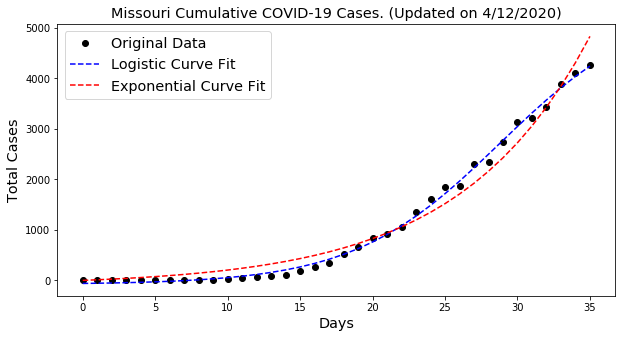



US state:  Alabama

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 3563
	Confirmed cases on 4/5/2020 	 1765
	Ratio: 2.02
	Weekly increase: 101.9 %
	Daily increase: 10.6 % per day
	Doubling Time (represents recent growth): 6.9 days

** Based on Logistic Fit**

	R^2: 0.9979736383287466
	Doubling Time (during middle of growth):  11.8 (± 2.19 ) days

** Based on Exponential Fit **

	R^2: 0.9869945371255112
	Doubling Time (represents overall growth):  5.71 (± 0.67 ) days


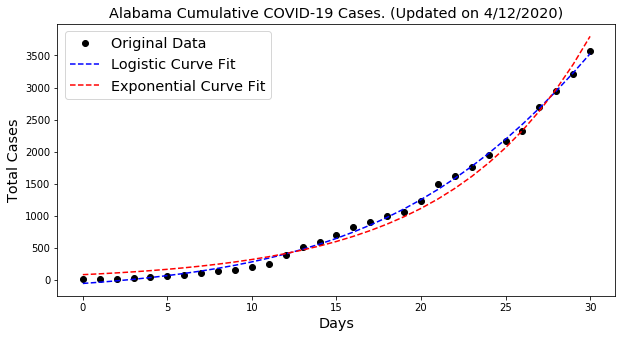



US state:  Arizona

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 3542
	Confirmed cases on 4/5/2020 	 2269
	Ratio: 1.56
	Weekly increase: 56.1 %
	Daily increase: 6.6 % per day
	Doubling Time (represents recent growth): 10.9 days

** Based on Logistic Fit**

	R^2: 0.9982883881810666
	Doubling Time (during middle of growth):  6.53 (± 0.31 ) days

** Based on Exponential Fit **

	R^2: 0.9780038604658685
	Doubling Time (represents overall growth):  6.88 (± 0.5 ) days


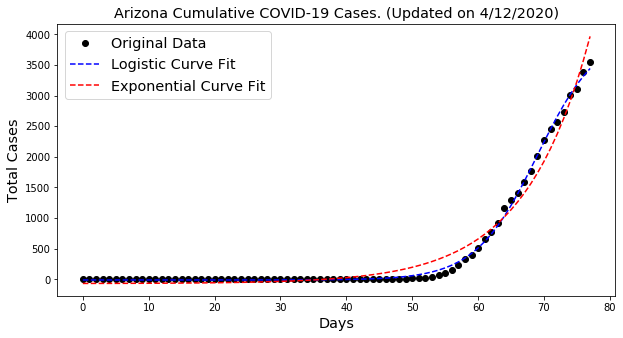



US state:  Wisconsin

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 3341
	Confirmed cases on 4/5/2020 	 2320
	Ratio: 1.44
	Weekly increase: 44.0 %
	Daily increase: 5.3 % per day
	Doubling Time (represents recent growth): 13.3 days

** Based on Logistic Fit**

	R^2: 0.9987294396044902
	Doubling Time (during middle of growth):  8.56 (± 0.7 ) days


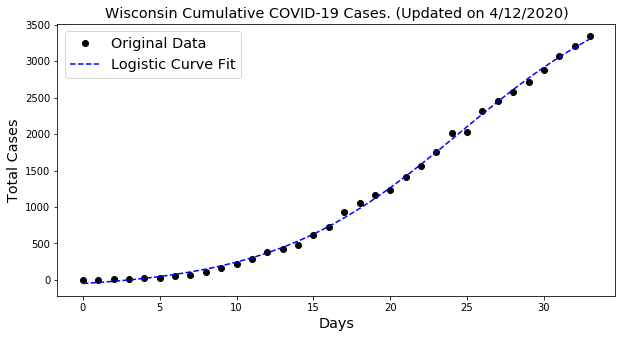



US state:  South Carolina

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 3320
	Confirmed cases on 4/5/2020 	 2049
	Ratio: 1.62
	Weekly increase: 62.0 %
	Daily increase: 7.1 % per day
	Doubling Time (represents recent growth): 10.1 days

** Based on Logistic Fit**

	R^2: 0.9977442537267552
	Doubling Time (during middle of growth):  7.15 (± 0.64 ) days

** Based on Exponential Fit **

	R^2: 0.9791810748939375
	Doubling Time (represents overall growth):  6.84 (± 0.94 ) days


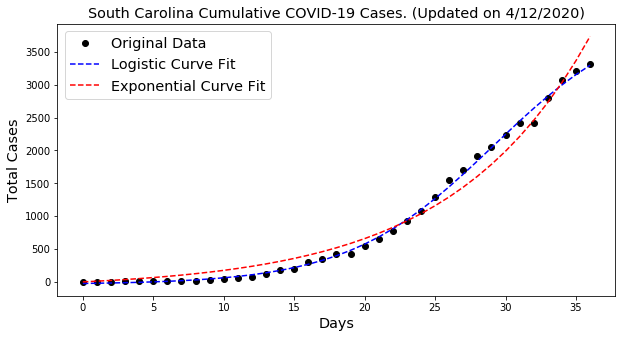



US state:  Nevada

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 2836
	Confirmed cases on 4/5/2020 	 1855
	Ratio: 1.53
	Weekly increase: 52.9 %
	Daily increase: 6.3 % per day
	Doubling Time (represents recent growth): 11.4 days

** Based on Logistic Fit**

	R^2: 0.9971497806193876
	Doubling Time (during middle of growth):  6.95 (± 0.64 ) days

** Based on Exponential Fit **

	R^2: 0.9731378865288504
	Doubling Time (represents overall growth):  7.44 (± 1.16 ) days


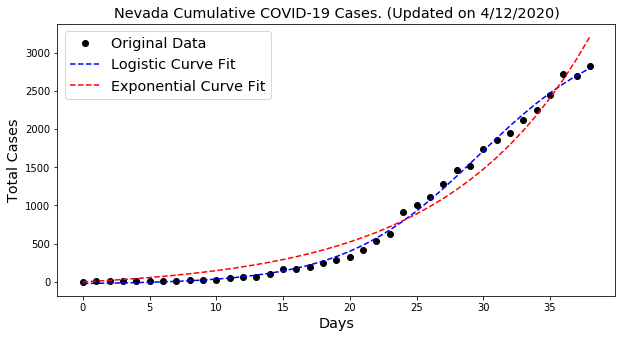



US state:  Mississippi

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 2781
	Confirmed cases on 4/5/2020 	 1638
	Ratio: 1.7
	Weekly increase: 69.8 %
	Daily increase: 7.9 % per day
	Doubling Time (represents recent growth): 9.2 days

** Based on Logistic Fit**

	R^2: 0.9984370518728529
	Doubling Time (during middle of growth):  10.47 (± 1.33 ) days

** Based on Exponential Fit **

	R^2: 0.9760950526269156
	Doubling Time (represents overall growth):  6.24 (± 1.01 ) days


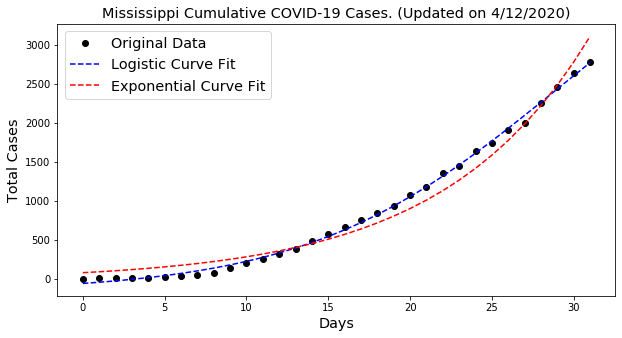



US state:  Rhode Island

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 2665
	Confirmed cases on 4/5/2020 	 922
	Ratio: 2.89
	Weekly increase: 189.0 %
	Daily increase: 16.4 % per day
	Doubling Time (represents recent growth): 4.6 days

** Based on Logistic Fit**

	R^2: 0.9956550900546114
	Doubling Time (during middle of growth):  9.44 (± 1.04 ) days

** Based on Exponential Fit **

	R^2: 0.9956550902431897
	Doubling Time (represents overall growth):  4.72 (± 0.21 ) days


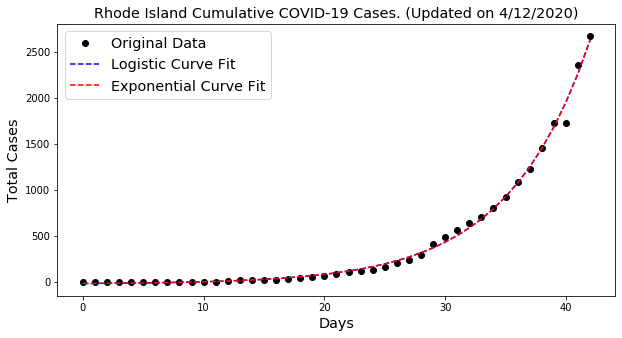



US state:  Utah

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 2303
	Confirmed cases on 4/5/2020 	 1601
	Ratio: 1.44
	Weekly increase: 43.8 %
	Daily increase: 5.3 % per day
	Doubling Time (represents recent growth): 13.3 days

** Based on Logistic Fit**

	R^2: 0.9971335291422347
	Doubling Time (during middle of growth):  7.3 (± 0.73 ) days

** Based on Exponential Fit **

	R^2: 0.9741138247331825
	Doubling Time (represents overall growth):  7.58 (± 1.24 ) days


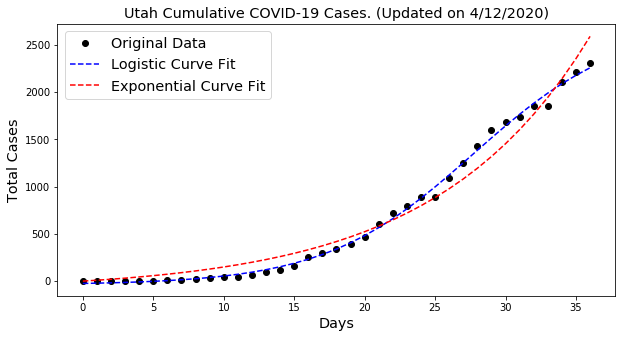



US state:  Oklahoma

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 1970
	Confirmed cases on 4/5/2020 	 1254
	Ratio: 1.57
	Weekly increase: 57.1 %
	Daily increase: 6.7 % per day
	Doubling Time (represents recent growth): 10.7 days

** Based on Logistic Fit**

	R^2: 0.9985165909302464
	Doubling Time (during middle of growth):  5.94 (± 0.39 ) days

** Based on Exponential Fit **

	R^2: 0.9750041215160387
	Doubling Time (represents overall growth):  7.0 (± 1.07 ) days


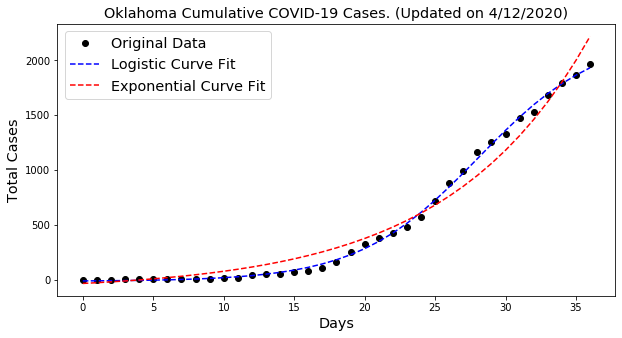



US state:  Kentucky

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 1963
	Confirmed cases on 4/5/2020 	 955
	Ratio: 2.06
	Weekly increase: 105.5 %
	Daily increase: 10.8 % per day
	Doubling Time (represents recent growth): 6.7 days

** Based on Logistic Fit**

	R^2: 0.9907648125738159
	Doubling Time (during middle of growth):  11.81 (± 3.4 ) days

** Based on Exponential Fit **

	R^2: 0.9903702627242864
	Doubling Time (represents overall growth):  7.03 (± 0.63 ) days


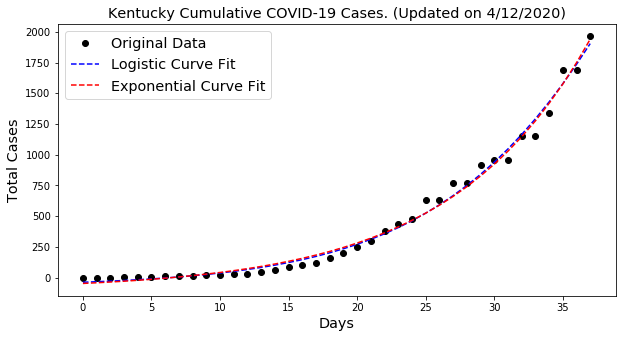



US state:  District of Columbia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 1875
	Confirmed cases on 4/5/2020 	 1002
	Ratio: 1.87
	Weekly increase: 87.1 %
	Daily increase: 9.4 % per day
	Doubling Time (represents recent growth): 7.7 days

** Based on Logistic Fit**

	R^2: 0.9990426701840657
	Doubling Time (during middle of growth):  7.38 (± 0.63 ) days

** Based on Exponential Fit **

	R^2: 0.9880180261821071
	Doubling Time (represents overall growth):  6.11 (± 0.8 ) days


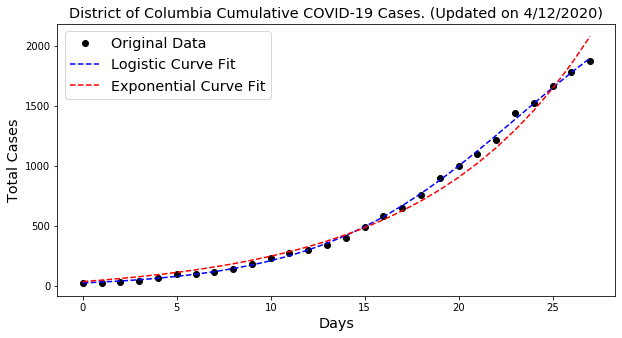



US state:  Delaware

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 1625
	Confirmed cases on 4/5/2020 	 673
	Ratio: 2.41
	Weekly increase: 141.5 %
	Daily increase: 13.4 % per day
	Doubling Time (represents recent growth): 5.5 days

** Based on Logistic Fit**

	R^2: 0.998247243150137
	Doubling Time (during middle of growth):  7.24 (± 0.71 ) days

** Based on Exponential Fit **

	R^2: 0.9953231156573246
	Doubling Time (represents overall growth):  5.52 (± 0.35 ) days


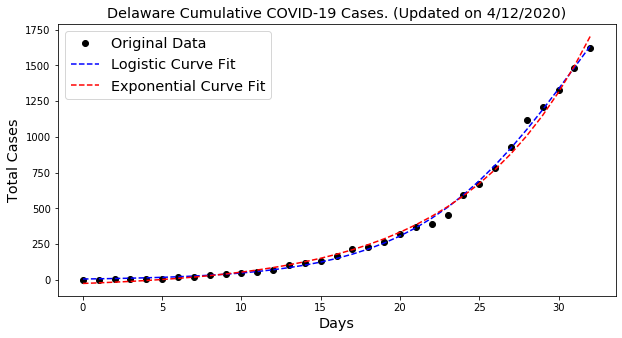



US state:  Minnesota

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 1621
	Confirmed cases on 4/5/2020 	 935
	Ratio: 1.73
	Weekly increase: 73.4 %
	Daily increase: 8.2 % per day
	Doubling Time (represents recent growth): 8.8 days

** Based on Logistic Fit**

	R^2: 0.9967126199353601
	Doubling Time (during middle of growth):  12.17 (± 2.02 ) days

** Based on Exponential Fit **

	R^2: 0.9918317538810916
	Doubling Time (represents overall growth):  8.6 (± 0.81 ) days


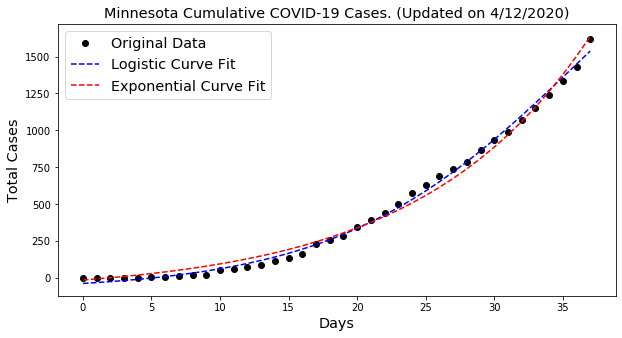



US state:  Iowa

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 1587
	Confirmed cases on 4/5/2020 	 869
	Ratio: 1.83
	Weekly increase: 82.6 %
	Daily increase: 9.0 % per day
	Doubling Time (represents recent growth): 8.1 days

** Based on Logistic Fit**

	R^2: 0.9987607954881704
	Doubling Time (during middle of growth):  8.08 (± 0.63 ) days

** Based on Exponential Fit **

	R^2: 0.992667177574566
	Doubling Time (represents overall growth):  7.15 (± 0.62 ) days


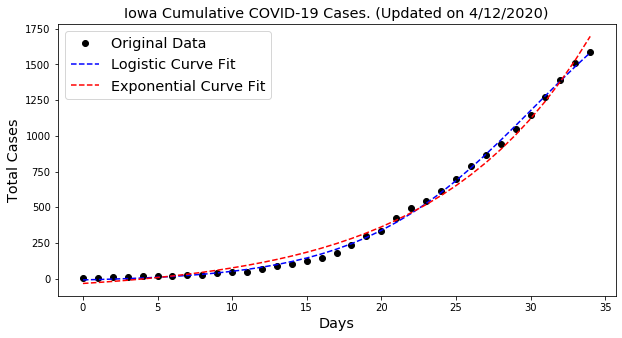



US state:  Oregon

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 1527
	Confirmed cases on 4/5/2020 	 1068
	Ratio: 1.43
	Weekly increase: 43.0 %
	Daily increase: 5.2 % per day
	Doubling Time (represents recent growth): 13.6 days

** Based on Logistic Fit**

	R^2: 0.9969066741863616
	Doubling Time (during middle of growth):  7.66 (± 0.69 ) days

** Based on Exponential Fit **

	R^2: 0.978613772435944
	Doubling Time (represents overall growth):  9.0 (± 1.2 ) days


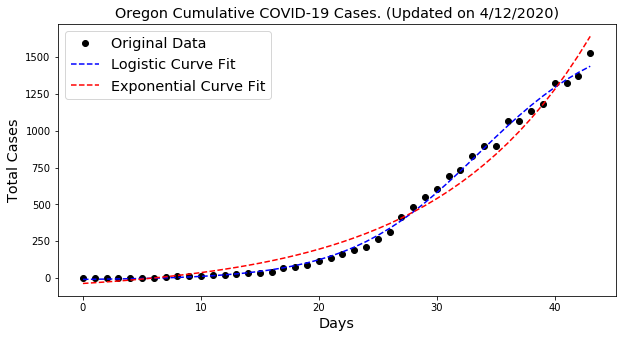



US state:  Idaho

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 1407
	Confirmed cases on 4/5/2020 	 1078
	Ratio: 1.31
	Weekly increase: 30.5 %
	Daily increase: 3.9 % per day
	Doubling Time (represents recent growth): 18.2 days

** Based on Logistic Fit**

	R^2: 0.996387203758345
	Doubling Time (during middle of growth):  4.06 (± 0.42 ) days


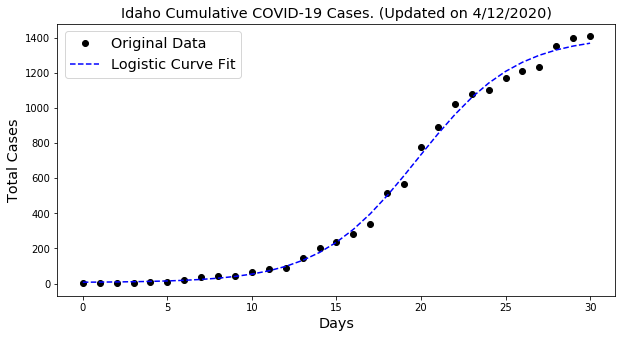



US state:  Kansas

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 1344
	Confirmed cases on 4/5/2020 	 751
	Ratio: 1.79
	Weekly increase: 79.0 %
	Daily increase: 8.7 % per day
	Doubling Time (represents recent growth): 8.3 days

** Based on Logistic Fit**

	R^2: 0.9981588759880745
	Doubling Time (during middle of growth):  7.61 (± 0.67 ) days

** Based on Exponential Fit **

	R^2: 0.9888551693391271
	Doubling Time (represents overall growth):  7.53 (± 0.81 ) days


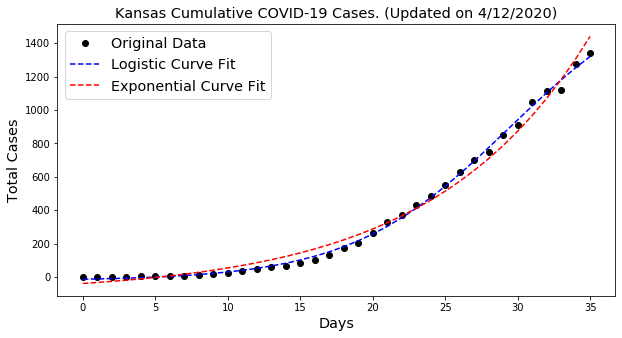



US state:  Arkansas

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 1280
	Confirmed cases on 4/5/2020 	 837
	Ratio: 1.53
	Weekly increase: 52.9 %
	Daily increase: 6.3 % per day
	Doubling Time (represents recent growth): 11.4 days

** Based on Logistic Fit**

	R^2: 0.9973649631619531
	Doubling Time (during middle of growth):  13.87 (± 3.47 ) days

** Based on Exponential Fit **

	R^2: 0.9724612086896198
	Doubling Time (represents overall growth):  7.72 (± 1.61 ) days


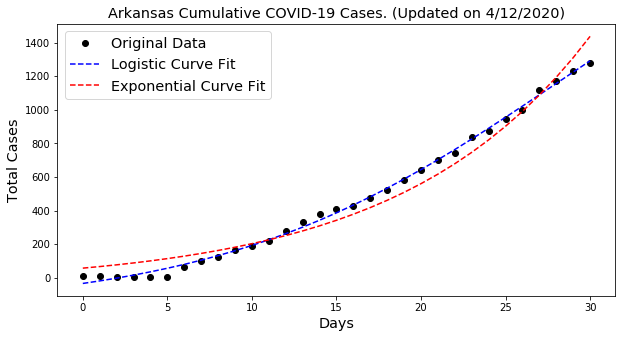



US state:  New Mexico

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 1245
	Confirmed cases on 4/5/2020 	 624
	Ratio: 2.0
	Weekly increase: 99.5 %
	Daily increase: 10.4 % per day
	Doubling Time (represents recent growth): 7.0 days

** Based on Logistic Fit**

	R^2: 0.9960952731987289
	Doubling Time (during middle of growth):  8.26 (± 1.3 ) days

** Based on Exponential Fit **

	R^2: 0.9932277195870229
	Doubling Time (represents overall growth):  6.59 (± 0.55 ) days


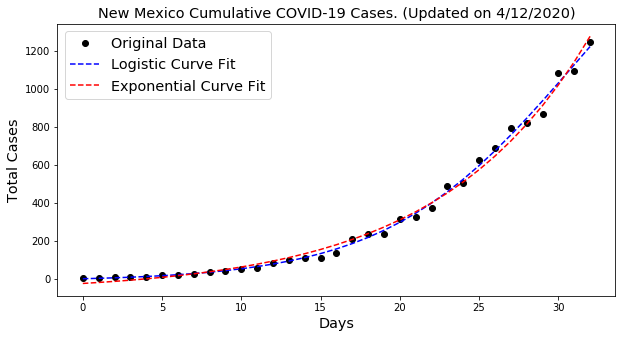



US state:  New Hampshire

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 929
	Confirmed cases on 4/5/2020 	 621
	Ratio: 1.5
	Weekly increase: 49.6 %
	Daily increase: 5.9 % per day
	Doubling Time (represents recent growth): 12.0 days

** Based on Logistic Fit**

	R^2: 0.9973241581471637
	Doubling Time (during middle of growth):  6.29 (± 0.51 ) days

** Based on Exponential Fit **

	R^2: 0.9770634781827838
	Doubling Time (represents overall growth):  8.42 (± 1.15 ) days


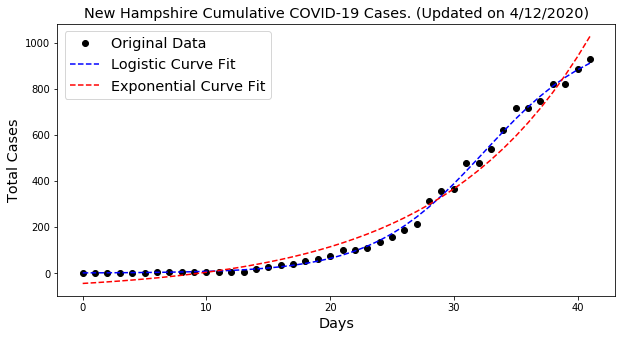



US state:  Puerto Rico

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 897
	Confirmed cases on 4/5/2020 	 475
	Ratio: 1.89
	Weekly increase: 88.8 %
	Daily increase: 9.5 % per day
	Doubling Time (represents recent growth): 7.6 days

** Based on Logistic Fit**

	R^2: 0.9949954199079528
	Doubling Time (during middle of growth):  6.92 (± 1.26 ) days

** Based on Exponential Fit **

	R^2: 0.9872637836226024
	Doubling Time (represents overall growth):  7.27 (± 1.11 ) days


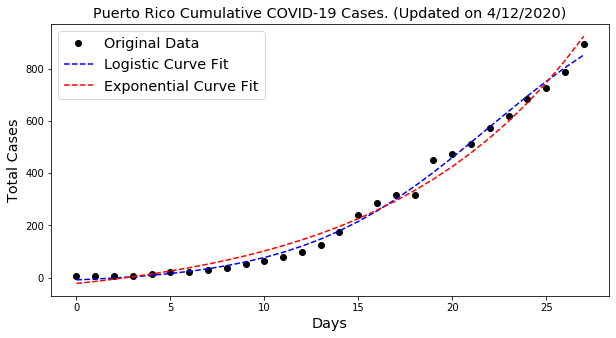



US state:  Nebraska

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 791
	Confirmed cases on 4/5/2020 	 364
	Ratio: 2.17
	Weekly increase: 117.3 %
	Daily increase: 11.7 % per day
	Doubling Time (represents recent growth): 6.3 days

** Based on Logistic Fit**

	R^2: 0.9987378335469416
	Doubling Time (during middle of growth):  8.15 (± 0.63 ) days

** Based on Exponential Fit **

	R^2: 0.9963815854701685
	Doubling Time (represents overall growth):  5.88 (± 0.29 ) days


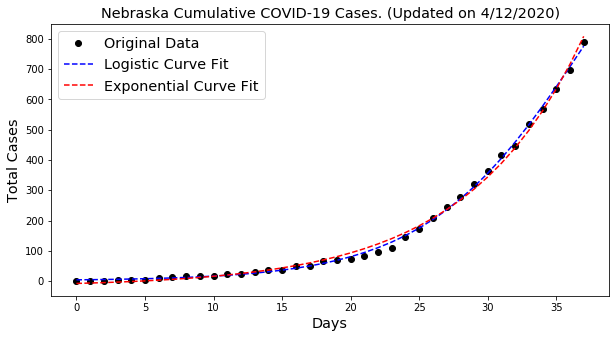



US state:  South Dakota

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 730
	Confirmed cases on 4/5/2020 	 240
	Ratio: 3.04
	Weekly increase: 204.2 %
	Daily increase: 17.2 % per day
	Doubling Time (represents recent growth): 4.4 days

** Based on Logistic Fit**

	R^2: 0.9992455899074858
	Doubling Time (during middle of growth):  8.93 (± nan ) days

** Based on Exponential Fit **

	R^2: 0.9992455899903161
	Doubling Time (represents overall growth):  4.47 (± 0.1 ) days


C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in sqrt


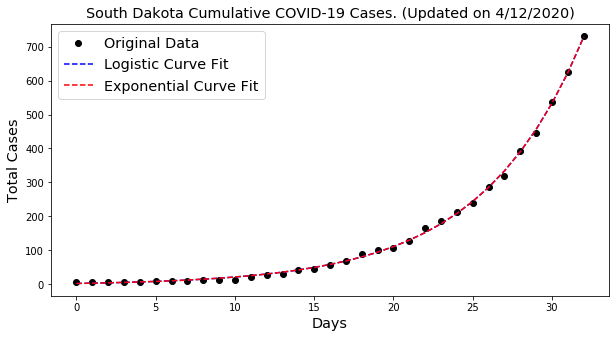



US state:  Vermont

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 727
	Confirmed cases on 4/5/2020 	 512
	Ratio: 1.42
	Weekly increase: 42.0 %
	Daily increase: 5.1 % per day
	Doubling Time (represents recent growth): 13.8 days

** Based on Logistic Fit**

	R^2: 0.9977577484721314
	Doubling Time (during middle of growth):  7.66 (± 0.71 ) days

** Based on Exponential Fit **

	R^2: 0.9837229614791632
	Doubling Time (represents overall growth):  9.51 (± 1.45 ) days


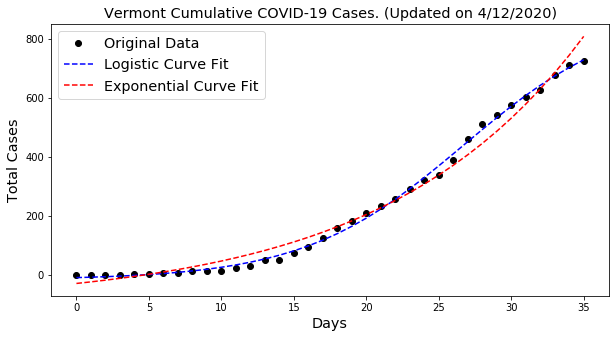



US state:  Maine

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 633
	Confirmed cases on 4/5/2020 	 470
	Ratio: 1.35
	Weekly increase: 34.7 %
	Daily increase: 4.3 % per day
	Doubling Time (represents recent growth): 16.3 days

** Based on Logistic Fit**

	R^2: 0.9974477723584898
	Doubling Time (during middle of growth):  7.82 (± 0.89 ) days

** Based on Exponential Fit **

	R^2: 0.9713677408330312
	Doubling Time (represents overall growth):  10.26 (± 2.59 ) days


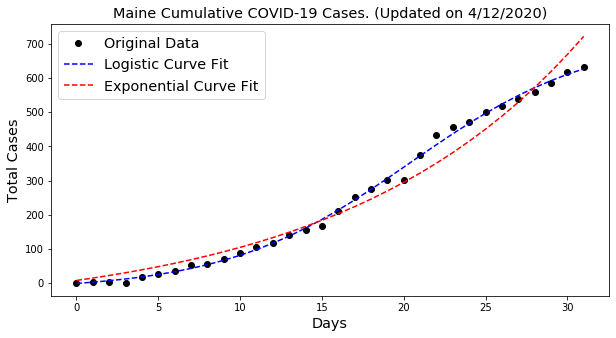



US state:  West Virginia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 593
	Confirmed cases on 4/5/2020 	 324
	Ratio: 1.83
	Weekly increase: 83.0 %
	Daily increase: 9.0 % per day
	Doubling Time (represents recent growth): 8.0 days

** Based on Logistic Fit**

	R^2: 0.9959758619957576
	Doubling Time (during middle of growth):  6.92 (± 1.26 ) days

** Based on Exponential Fit **

	R^2: 0.9882538492511468
	Doubling Time (represents overall growth):  7.93 (± 1.36 ) days


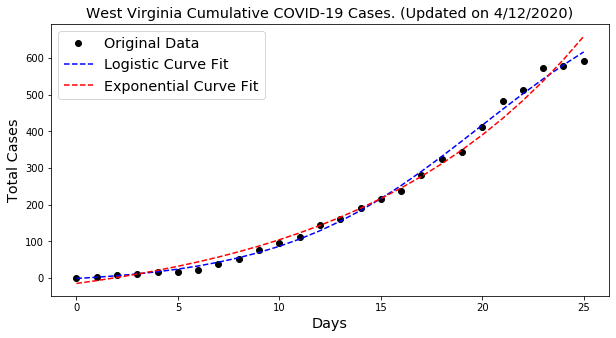



US state:  Hawaii

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 499
	Confirmed cases on 4/5/2020 	 371
	Ratio: 1.35
	Weekly increase: 34.5 %
	Daily increase: 4.3 % per day
	Doubling Time (represents recent growth): 16.4 days

** Based on Logistic Fit**

	R^2: 0.9962379698677216
	Doubling Time (during middle of growth):  6.4 (± 0.67 ) days

** Based on Exponential Fit **

	R^2: 0.9743897566013486
	Doubling Time (represents overall growth):  11.13 (± 2.3 ) days


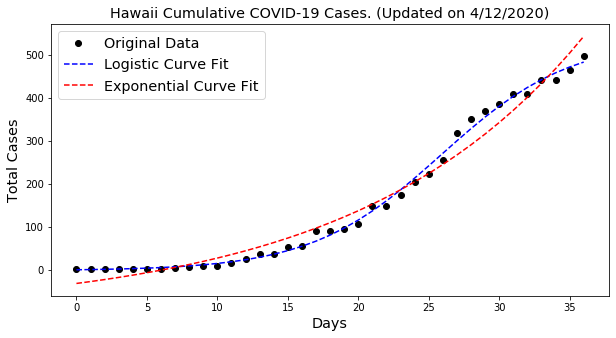



US state:  Montana

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 387
	Confirmed cases on 4/5/2020 	 286
	Ratio: 1.35
	Weekly increase: 35.3 %
	Daily increase: 4.4 % per day
	Doubling Time (represents recent growth): 16.0 days

** Based on Logistic Fit**

	R^2: 0.9974455159322034
	Doubling Time (during middle of growth):  6.79 (± 0.72 ) days

** Based on Exponential Fit **

	R^2: 0.9724906622689687
	Doubling Time (represents overall growth):  11.95 (± 3.53 ) days


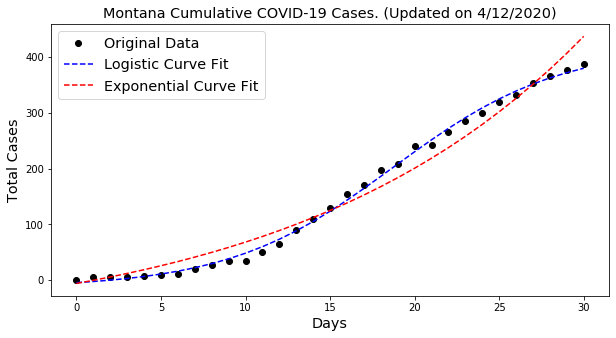



US state:  North Dakota

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 308
	Confirmed cases on 4/5/2020 	 207
	Ratio: 1.49
	Weekly increase: 48.8 %
	Daily increase: 5.8 % per day
	Doubling Time (represents recent growth): 12.2 days

** Based on Logistic Fit**

	R^2: 0.9982331848078846
	Doubling Time (during middle of growth):  7.8 (± 0.75 ) days

** Based on Exponential Fit **

	R^2: 0.9883125723109737
	Doubling Time (represents overall growth):  12.43 (± 2.3 ) days


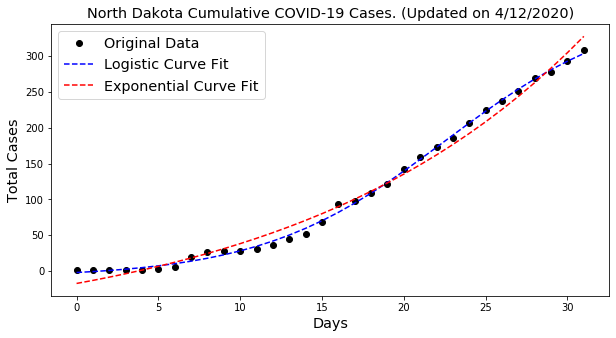



US state:  Alaska

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 272
	Confirmed cases on 4/5/2020 	 185
	Ratio: 1.47
	Weekly increase: 47.0 %
	Daily increase: 5.7 % per day
	Doubling Time (represents recent growth): 12.6 days

** Based on Logistic Fit**

	R^2: 0.9966341299946623
	Doubling Time (during middle of growth):  7.98 (± 1.12 ) days

** Based on Exponential Fit **

	R^2: 0.9861315198009285
	Doubling Time (represents overall growth):  13.64 (± 3.14 ) days


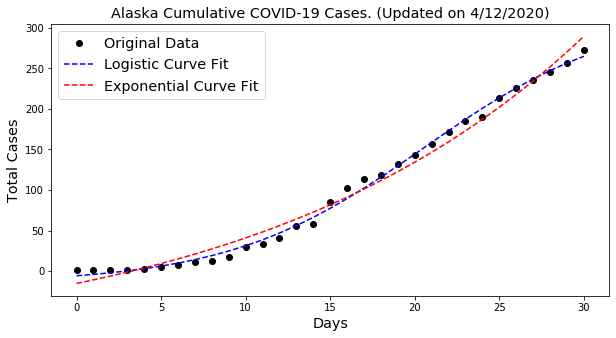



US state:  Wyoming

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 270
	Confirmed cases on 4/5/2020 	 197
	Ratio: 1.37
	Weekly increase: 37.1 %
	Daily increase: 4.6 % per day
	Doubling Time (represents recent growth): 15.4 days

** Based on Logistic Fit**

	R^2: 0.9965966930026826
	Doubling Time (during middle of growth):  6.59 (± 0.77 ) days

** Based on Exponential Fit **

	R^2: 0.9804544417488744
	Doubling Time (represents overall growth):  13.87 (± 3.67 ) days


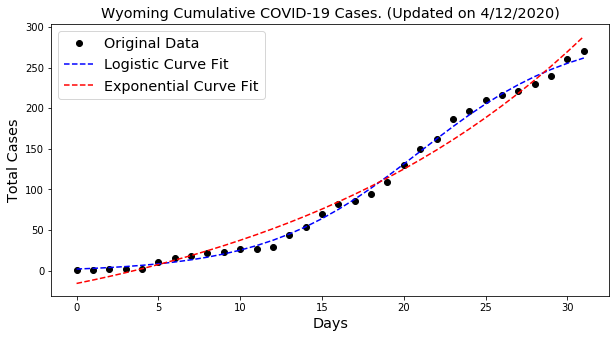



US state:  Guam

** Based on Most Recent Week of Data **

	Confirmed cases on 4/12/2020 	 133
	Confirmed cases on 4/5/2020 	 112
	Ratio: 1.19
	Weekly increase: 18.8 %
	Daily increase: 2.5 % per day
	Doubling Time (represents recent growth): 28.2 days

** Based on Logistic Fit**

	R^2: 0.9926806864304335
	Doubling Time (during middle of growth):  10.28 (± 3.33 ) days

** Based on Exponential Fit **

	R^2: 0.9838290683394104
	Doubling Time (represents overall growth):  20.78 (± 8.92 ) days


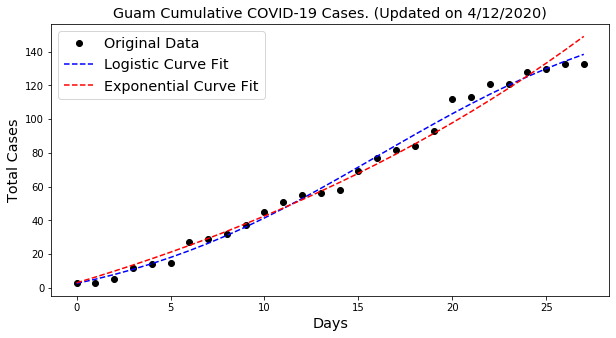



US state:  Grand Princess

** Based on Logistic Fit**

	R^2: 0.9967947201167052
	Doubling Time (during middle of growth):  0.12 (± 1.98 ) days


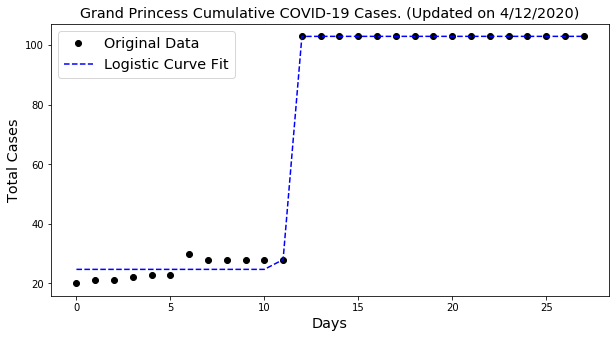

In [8]:
topusstates = usstatesummary[usstatesummary[mostrecentdate] >= 100]
print(topusstates)

print('\n');
inferreddoublingtime = []
recentdoublingtime = []
errors = []
states = []

for state in topusstates.index.values:
    print('US state: ', state)
    a = plotCases(uscases,'Province/State', state)
    if a:
        states.append(state)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

New York's COVID-19 growth appears to be consistent with a logistic trend, but it might be too early to tell. Other states where the growth seems to be more exponential are Illinois, California, and Washington. Most other states appear to be within the starting phase of a logistic trend, but it might be too early to say, based on the average doubling time (which is 5 days). 

Currently, cases double in New York roughly 8 days, while Massachusetts doubles every 5 days. Michigan's stay-at-home order is set to expire tomorrow if the Governor of that state chooses not to extend the lockdown. However, COVID-19 growth appears to be on the logistic trend, and cases are doubling every 11 days.

### Conclusion

There is still more to learn about this virus. We're still trying to come up with ways to track its behavior, which can only happen with more testing. One thing that can be certain is that this crisis is nowhere near over. As data comes more available, we will be taking steps to analyze it, which will provide more insight into where we need to focus our resources.